In [1]:
from glob import glob
from collections import Counter
from collections import defaultdict

import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import gseapy as gp
import gseapy.plot as gplot
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['pdf.fonttype'] = 42  # TrueType fonts
matplotlib.rcParams['ps.fonttype'] = 42   # TrueType fonts
matplotlib.rcParams['axes.unicode_minus'] = False # Fix unicode symbols
matplotlib.rcParams['figure.figsize'] = (8.27, 11.69)
# matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['savefig.bbox'] = None
matplotlib.rcParams['figure.constrained_layout.use'] = False


In [2]:
#!/usr/bin/env python3
"""
Complete Figure Generation Script for Advanced Materials Journal
PSNP Impact on PBMC scRNA-seq Analysis

This script generates ALL MAIN FIGURES (1-6) and ALL SUPPLEMENTARY FIGURES according to FIGURES.md specifications

"""

import logging
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec

# Try to import upsetplot
try:
    from upsetplot import UpSet, from_contents
except ImportError:
    logging.warning("upsetplot not found, installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'upsetplot'])
    from upsetplot import UpSet, from_contents

# ============================================================
# LOGGING CONFIGURATION
# ============================================================

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

# ============================================================
# SETUP AND CONFIGURATION
# ============================================================

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (8.27, 11.69)
# plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.bbox'] = None
plt.rcParams['figure.constrained_layout.use'] = False

# Output directory
FIG_DIR = Path('./fig')
FIG_DIR.mkdir(exist_ok=True)


# SAMPLE_COLORS = {
#     'sample_1': '#d01c8b', '40nm': '#d01c8b',
#     'sample_2': '#f1b6da', '200nm': '#f1b6da',
#     'sample_3': '#b8e186', '40+200nm': '#b8e186',
#     'sample_4': '#4dac26', 'Untreated': '#4dac26', 'Control': '#4dac26'
# }
#3287be

SAMPLE_COLORS = {
    'sample_1': '#3287be', '40nm': '#3287be',
    'sample_2': '#f0b4dc', '200nm': '#f0b4dc',
    'sample_3': '#b9e187', '40+200nm': '#b9e187',
    'sample_4': '#ff7d55', 'Untreated': '#4dac26', 'Control': '#ff7d55'
}

CELL_TYPE_COLORS = {
    'B cell': '#abd9e9',
    'CD4+ T cell': '#fdae61',
    'Cytotoxic T cell': '#2c7bb6',# '#ffffbf',
    'CD14+ monocyte': '#d7191c',
    'Natural killer cell': '#8856a7'
}

CELL_TYPE_SHORT_MAP = {
    'B cell': 'B cell',
    'CD4+ T cell': 'CD4+',
    'Cytotoxic T cell': 'CD8+',
    'CD14+ monocyte': 'Monocyte',
    'Natural killer cell': 'NK'
}

CELL_TYPE_SHORT_MAP_ALT = {
    'B cell': 'B cell',
    'CD4+ T cell': 'CD4+_T_cell',
    'Cytotoxic T cell': 'CD8+_T_cell',
    'CD14+ monocyte': 'Monocyte',
    'Natural killer cell': 'NK_cell'
}

REG_COLORS = {
    'Upregulated': '#d7191c',
    'Downregulated': '#2c7bb6',
    'Not Significant': '#B0B0B0'
}

SAMPLE_NAMES = {
    'sample_1': '40nm',
    'sample_2': '200nm',
    'sample_3': '40+200nm',
    'sample_4': 'Control'
}

CELL_TYPE_ORDER = [
    'CD14+ monocyte',
    'B cell',
    'CD4+ T cell',
    'Cytotoxic T cell',
    'Natural killer cell'
]

samples = ['40nm', '200nm', '40+200nm']

logger.info("Configuration loaded")
logger.info(f"Output directory: {FIG_DIR.absolute()}")

cmap = 'RdBu_r'
cell_type_col = 'CoDi_dist'  # Use CoDi_dist annotation as specified
sample_col = 'sample'
# ============================================================
# LOAD DATA
# ============================================================

logger.info("Loading differential expression and pathway enrichment results...")

# Load DE results
de_results_path = Path('./results/de_results_CoDi_dist.xlsx')
de_results = {}
if de_results_path.exists():
    logger.info(f"Loading DE results from {de_results_path}")
    excel_file = pd.ExcelFile(de_results_path)
    for sheet_name in excel_file.sheet_names:
        de_results[sheet_name] = excel_file.parse(sheet_name)
    logger.info(f"✓ Loaded {len(de_results)} DE result sheets")
else:
    logger.error(f"DE results file not found: {de_results_path}")
    raise FileNotFoundError(f"Required file not found: {de_results_path}")

# Load GSE results
gse_results_path = Path('../data/Pathways_KEGG_cleaned.xlsx')
gse_results = {}
if gse_results_path.exists():
    logger.info(f"Loading GSE results from {gse_results_path}")
    gse_file = pd.ExcelFile(gse_results_path)
    for sheet_name in gse_file.sheet_names:
        gse_results[sheet_name] = gse_file.parse(sheet_name)
    logger.info(f"✓ Loaded {len(gse_results)} GSE result sheets")
else:
    logger.warning(f"GSE results file not found: {gse_results_path}")


def get_condition_label(condition):
    """
    Convert condition code to human-readable label.
    """
    cond_map = {
        '40nm': '40 nm',
        '200nm': '200 nm',
        '40+200nm': 'MIX (40 + 200 nm)',
        'Control': 'Control'
    }
    return cond_map.get(condition, condition)

def get_gse_sheet_name(cell_type, condition):
    """
    Convert cell type and condition to GSE sheet name format.
    GSE sheets use format: CellType_sample_X
    e.g., "Monocyte_sample_1", "B_cell_sample_2"
    """
    ct_map = {
        'B cell': 'B_cell',
        'CD4+ T cell': 'CD4+_T_cell',
        'Cytotoxic T cell': 'Cytotoxic_T_cell',
        'CD14+ monocyte': 'Monocyte',
        'Natural killer cell': 'Natural_killer_cell'
    }

    # Condition to sample mapping
    cond_map = {
        '40nm': '40 nm',
        '200nm': '200 nm',
        '40+200nm': 'MIX (40 + 200 nm)',
    }

    ct_name = ct_map.get(cell_type, cell_type.replace(' ', '_'))
    sample_name = cond_map.get(condition, condition)
    return f"{ct_name}_{sample_name}"

# Helper function for sheet names
def get_sheet_name_fig2(cell_type, condition):
    ct_map = {
        'B cell': 'B_cell',
        'CD4+ T cell': 'CD4+_T_cell',
        'Cytotoxic T cell': 'Cytotoxic_T_cell',
        'CD14+ monocyte': 'CD14+_monocyte',
        'Natural killer cell': 'Natural_killer_cell'
    }
    cond_map = {'40nm': 'sample_1', '200nm': 'sample_2', '40+200nm': 'sample_3'}
    return f"{ct_map.get(cell_type, cell_type.replace(' ', '_'))}_{cond_map[condition]}"

22:31:11 - INFO - Configuration loaded
22:31:11 - INFO - Output directory: /Users/vladimirk/repositories/nano/notebooks/fig
22:31:11 - INFO - Loading differential expression and pathway enrichment results...
22:31:11 - INFO - Loading DE results from results/de_results_CoDi_dist.xlsx
22:31:15 - INFO - ✓ Loaded 15 DE result sheets
22:31:15 - INFO - Loading GSE results from ../data/Pathways_KEGG_cleaned.xlsx
22:31:15 - INFO - ✓ Loaded 15 GSE result sheets


# ============================================================
# FIGURE 1: Overview - scRNA-seq Experimental Setup and Global Analysis
# ============================================================

20:31:40 - INFO -   Loaded data from: ../data/merged_harmony.h5ad
20:31:40 - INFO - Creating Figure 1D (Cell Composition)...


['sample_1', 'sample_1', 'sample_1', 'sample_1', 'sample_1', ..., 'sample_4', 'sample_4', 'sample_4', 'sample_4', 'sample_4']
Length: 33814
Categories (4, object): ['sample_1', 'sample_2', 'sample_3', 'sample_4']
sample_4
sample_1
sample_2
sample_3


20:31:40 - INFO - maxp pruned
20:31:40 - INFO - LTSH dropped
20:31:40 - INFO - cmap pruned
20:31:40 - INFO - kern dropped
20:31:40 - INFO - post pruned
20:31:40 - INFO - PCLT dropped
20:31:40 - INFO - GPOS pruned
20:31:40 - INFO - GSUB pruned
20:31:40 - INFO - JSTF dropped
20:31:40 - INFO - DSIG dropped
20:31:40 - INFO - name pruned
20:31:40 - INFO - glyf pruned
20:31:40 - INFO - Added gid0 to subset
20:31:40 - INFO - Added first four glyphs to subset
20:31:40 - INFO - Closing glyph list over 'GSUB': 16 glyphs before
20:31:40 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'percent', 'period', 'seven', 'six', 'space', 'three', 'two', 'zero']
20:31:40 - INFO - Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
20:31:40 - INFO - Closed glyph list over 'GSUB': 16 glyphs after
20:31:40 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'percent', 'period', 'seven

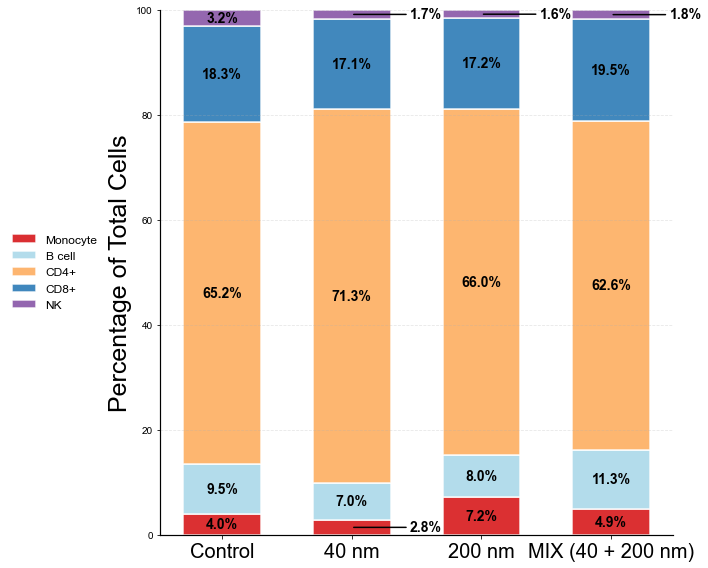

In [3]:
# ============================================================
# FIGURE 1D (Separate): Cell Composition Stacked Bar Chart
# ============================================================
cell_type_col = 'CoDi_dist'  # Use CoDi_dist annotation as specified
sample_col = 'sample'
# Load AnnData object
adata_path = '../data/merged_harmony.h5ad'
adata = sc.read_h5ad(adata_path)
logger.info(f"  Loaded data from: {adata_path}")
        

if adata is None:
    raise FileNotFoundError("Could not find AnnData file")

# Build composition data (needed for separate Figure 1D/1E cells)
composition_data = []
print(adata.obs[sample_col].values)
for sample in ['sample_4', 'sample_1', 'sample_2', 'sample_3']:
    if sample in adata.obs[sample_col].values:
        print(sample)
        sample_mask = adata.obs[sample_col] == sample
        total_cells = sample_mask.sum()
        for ct in CELL_TYPE_ORDER:
            ct_mask = adata.obs[cell_type_col] == ct
            count = (sample_mask & ct_mask).sum()
            percentage = (count / total_cells * 100) if total_cells > 0 else 0
            composition_data.append({'Condition': SAMPLE_NAMES.get(sample, sample), 'Cell Type': ct, 'Percentage': percentage, 'Count': count})

comp_df = pd.DataFrame(composition_data)

logger.info("Creating Figure 1D (Cell Composition)...")

fig1d, ax_1d_sep = plt.subplots(figsize=(10, 8))

conditions = ['Control', '40nm', '200nm', '40+200nm']
x = np.arange(len(conditions))
width = 0.6

bottom = np.zeros(len(conditions))
for ct in CELL_TYPE_ORDER:
    heights = [comp_df[(comp_df['Condition'] == cond) & (comp_df['Cell Type'] == ct)]['Percentage'].values[0]
               if len(comp_df[(comp_df['Condition'] == cond) & (comp_df['Cell Type'] == ct)]) > 0 else 0
               for cond in conditions]
    ax_1d_sep.bar(x, heights, width, bottom=bottom, label=CELL_TYPE_SHORT_MAP[ct], 
                  color=CELL_TYPE_COLORS[ct], edgecolor='white', linewidth=1.5, alpha=0.9)
    
    for i, height in enumerate(heights):
        if height > 3:
            ax_1d_sep.text(x[i], bottom[i] + height/2, f'{height:.1f}%', 
                          ha='center', va='center', fontsize=14, fontweight='bold', color='black')
        else:
            y_center = bottom[i] + height / 2
            ax_1d_sep.annotate(
            f'{height:.1f}%',
            xy=(x[i], y_center),             # segment location
            xytext=(x[i] + 0.45, y_center),  # move label right
            ha='left',
            va='center',
            fontsize=14,
            fontweight='bold',
            arrowprops=dict(
                arrowstyle='-',
                lw=1.5,
                color='black'
            ),
            clip_on=False
        )
            # ax_1d_sep.text(x[i], bottom[i] + height/2, f'{height:.1f}%', 
            #               ha='center', va='center', fontsize=14, fontweight='bold', color='black')
    bottom += heights

ax_1d_sep.set_xticks(x)
ax_1d_sep.set_xticklabels([get_condition_label(c) for c in conditions], fontsize=20)
ax_1d_sep.set_ylabel('Percentage of Total Cells', fontsize=25)
ax_1d_sep.set_ylim(0, 100)
# ax_1d_sep.set_title('Percentage of each cell type within sample', fontsize=16, fontweight='bold', pad=15)
ax_1d_sep.legend(frameon=False, fontsize=12, ncol=1, loc='center right', bbox_to_anchor=(-0.1,0.5))
ax_1d_sep.spines['top'].set_visible(False)
ax_1d_sep.spines['right'].set_visible(False)
ax_1d_sep.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(FIG_DIR / 'Figure_1d_composition.pdf', bbox_inches='tight')
plt.savefig(FIG_DIR / 'Figure_1d_composition.png', bbox_inches='tight', dpi=300)
logger.info("✓ Figure 1D (Cell Composition) saved as Figure_1d_composition.pdf and .png")

20:31:41 - INFO - Creating Figure 1E (Transposed Cell Count Table)...
20:31:41 - INFO - maxp pruned
20:31:41 - INFO - LTSH dropped
20:31:41 - INFO - cmap pruned
20:31:41 - INFO - kern dropped
20:31:41 - INFO - post pruned
20:31:41 - INFO - PCLT dropped
20:31:41 - INFO - GPOS pruned
20:31:41 - INFO - GSUB pruned
20:31:41 - INFO - JSTF dropped
20:31:41 - INFO - DSIG dropped
20:31:41 - INFO - name pruned
20:31:41 - INFO - glyf pruned
20:31:41 - INFO - Added gid0 to subset
20:31:41 - INFO - Added first four glyphs to subset
20:31:41 - INFO - Closing glyph list over 'GSUB': 30 glyphs before
20:31:41 - INFO - Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'K', 'M', 'N', 'c', 'e', 'eight', 'five', 'four', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'plus', 'r', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
20:31:41 - INFO - Glyph IDs:   [0, 1, 2, 3, 14, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 37, 38, 39, 46, 48, 49, 70, 72, 79, 80, 81, 82, 85, 87, 92]
20:31:41 - INFO

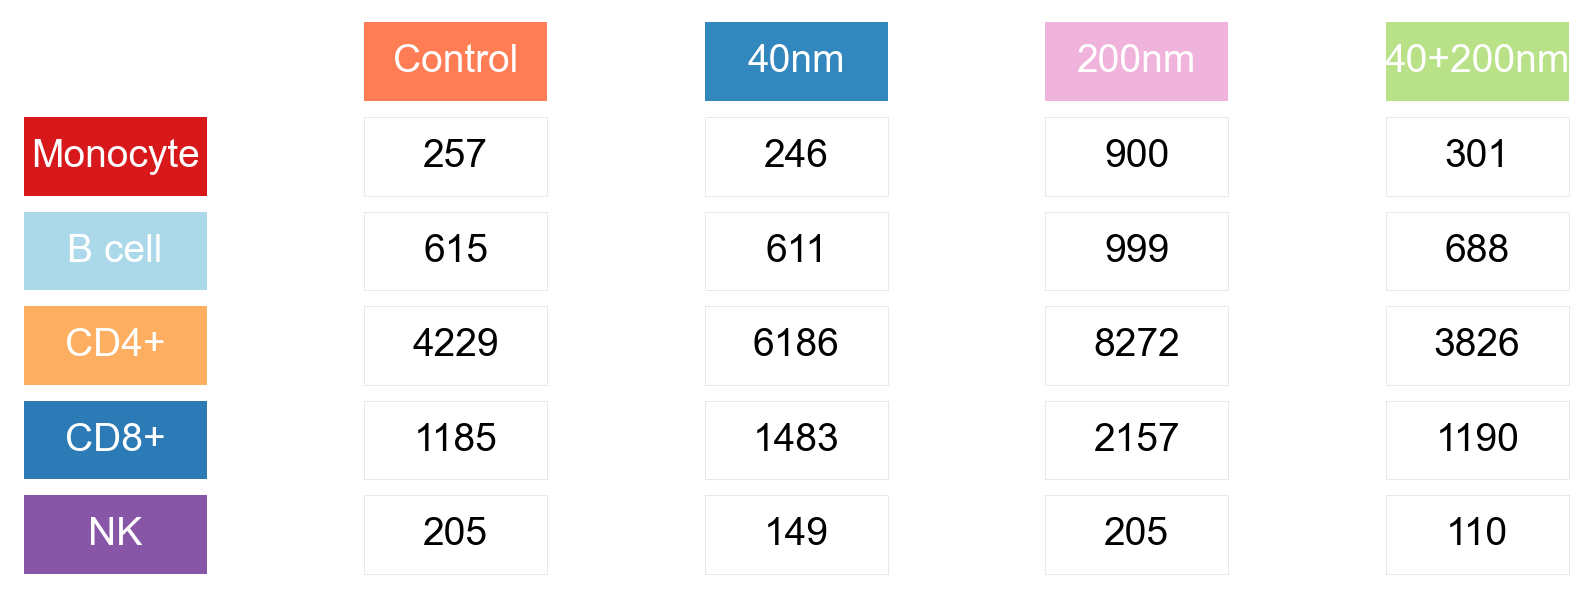

In [4]:
# ============================================================
# FIGURE 1E (Separate): Transposed Cell Count Table
# Rows = Cell Types (colored), Columns = Conditions (colored)
# With customizable spacing between columns
# ============================================================
logger.info("Creating Figure 1E (Transposed Cell Count Table)...")

# ===========================================
# ADJUSTABLE PARAMETERS
# ===========================================
COLUMN_GAP = 0.19       # Gap between columns (adjust this!)
ROW_GAP = 0.02          # Gap between rows
CELL_WIDTH = 0.22       # Width of each cell
CELL_HEIGHT = 0.1      # Height of each cell
ROW_LABEL_WIDTH = 0.22  # Width of row label column
FONT_SIZE = 39          # Font size for cell text
# ===========================================

# Create transposed cell count table data: rows = cell types, columns = conditions
conditions = ['Control', '40nm', '200nm', '40+200nm']
table_data_transposed = []
for ct in CELL_TYPE_ORDER:
    row = []
    for cond in conditions:
        count = comp_df[(comp_df['Condition'] == cond) & (comp_df['Cell Type'] == ct)]['Count'].values
        row.append(int(count[0]) if len(count) > 0 else 0)
    table_data_transposed.append(row)

# Row labels = cell types (short names)
row_labels = [CELL_TYPE_SHORT_MAP.get(ct, ct) for ct in CELL_TYPE_ORDER]

# Condition colors for column headers
CONDITION_COLORS = {
    'Control': '#33a02c',
    '40nm': '#d01c8b',
    '200nm': '#d95f02',
    '40+200nm': '#b8e186'
}

n_rows = len(CELL_TYPE_ORDER)
n_cols = len(conditions)

# Calculate total width and height
total_width = ROW_LABEL_WIDTH + COLUMN_GAP + n_cols * CELL_WIDTH + (n_cols - 1) * COLUMN_GAP
total_height = (n_rows + 1) * CELL_HEIGHT + n_rows * ROW_GAP  # +1 for header

# Create figure with size proportional to content
fig_width = total_width * 12  # Scale factor for figure size
fig_height = total_height * 12
fig1e, ax1e = plt.subplots(figsize=(fig_width, fig_height))
ax1e.axis('off')

# Starting positions
start_x = 0
start_y = total_height

# Draw column headers (conditions)
for j, cond in enumerate(conditions):
    x = start_x + ROW_LABEL_WIDTH + COLUMN_GAP + j * (CELL_WIDTH + COLUMN_GAP)
    y = start_y - CELL_HEIGHT
    
    rect = plt.Rectangle((x, y), CELL_WIDTH, CELL_HEIGHT, 
                          facecolor=SAMPLE_COLORS[cond], edgecolor='none')
    ax1e.add_patch(rect)
    ax1e.text(x + CELL_WIDTH/2, y + CELL_HEIGHT/2, cond, 
              ha='center', va='center', fontsize=FONT_SIZE, color='white') # fontweight='bold', 

# Draw row labels and data cells
for i, ct in enumerate(CELL_TYPE_ORDER):
    y = start_y - (i + 2) * CELL_HEIGHT - (i + 1) * ROW_GAP
    
    # Row label (cell type)
    rect = plt.Rectangle((start_x, y), ROW_LABEL_WIDTH, CELL_HEIGHT,
                          facecolor=CELL_TYPE_COLORS[ct], edgecolor='none')
    ax1e.add_patch(rect)
    ax1e.text(start_x + ROW_LABEL_WIDTH/2, y + CELL_HEIGHT/2, row_labels[i],
              ha='center', va='center', fontsize=FONT_SIZE, color='white') #  fontweight='bold',
    
    # Data cells
    for j, cond in enumerate(conditions):
        x = start_x + ROW_LABEL_WIDTH + COLUMN_GAP + j * (CELL_WIDTH + COLUMN_GAP)
        
        rect = plt.Rectangle((x, y), CELL_WIDTH, CELL_HEIGHT,
                              facecolor='white', edgecolor='lightgray', linewidth=0.5)
        ax1e.add_patch(rect)
        ax1e.text(x + CELL_WIDTH/2, y + CELL_HEIGHT/2, str(table_data_transposed[i][j]),
                  ha='center', va='center', fontsize=FONT_SIZE)

# Set axis limits based on actual content with small padding
padding = 0.02
ax1e.set_xlim(-padding, total_width + padding)
ax1e.set_ylim(-padding, total_height + padding)

# ax1e.set_title('e) Cell Counts by Cell Type and Condition', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(FIG_DIR / 'Figure_1e_transposed.pdf', bbox_inches='tight')
plt.savefig(FIG_DIR / 'Figure_1e_transposed.png', bbox_inches='tight', dpi=300)
logger.info("✓ Figure 1E (Transposed) saved as Figure_1e_transposed.pdf and .png")

20:31:42 - INFO -   Panel 1C: UMAP by cell type...
20:31:44 - INFO - maxp pruned
20:31:44 - INFO - LTSH dropped
20:31:44 - INFO - cmap pruned
20:31:44 - INFO - kern dropped
20:31:44 - INFO - post pruned
20:31:44 - INFO - PCLT dropped
20:31:44 - INFO - GPOS pruned
20:31:44 - INFO - GSUB pruned
20:31:44 - INFO - JSTF dropped
20:31:44 - INFO - DSIG dropped
20:31:44 - INFO - name pruned
20:31:44 - INFO - glyf pruned
20:31:44 - INFO - Added gid0 to subset
20:31:44 - INFO - Added first four glyphs to subset
20:31:44 - INFO - Closing glyph list over 'GSUB': 20 glyphs before
20:31:44 - INFO - Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'K', 'M', 'N', 'c', 'e', 'eight', 'four', 'l', 'n', 'nonmarkingreturn', 'o', 'plus', 'space', 't', 'y']
20:31:44 - INFO - Glyph IDs:   [0, 1, 2, 3, 14, 23, 27, 37, 38, 39, 46, 48, 49, 70, 72, 79, 81, 82, 87, 92]
20:31:44 - INFO - Closed glyph list over 'GSUB': 20 glyphs after
20:31:44 - INFO - Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'K', 'M', 'N', 

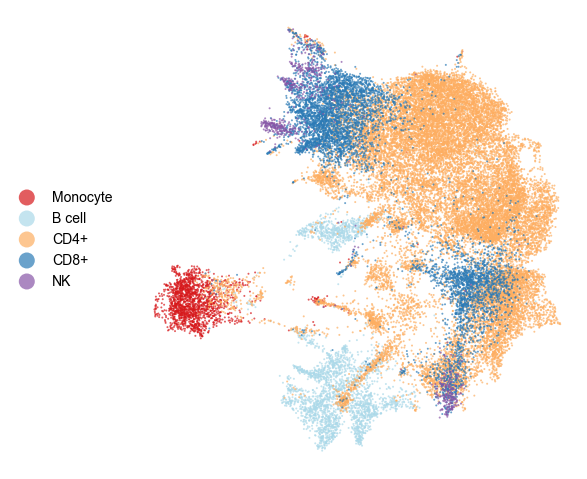

In [5]:

        
# Panel 1C: UMAP by cell type
logger.info("  Panel 1C: UMAP by cell type...")

fig, ax_1c = plt.subplots(figsize=(8, 14))
umap_coords = adata.obsm['X_umap_after']

for ct in CELL_TYPE_ORDER:
    mask = adata.obs[cell_type_col] == ct
    if mask.sum() > 0:
        ax_1c.scatter(umap_coords[mask, 0], umap_coords[mask, 1],
                     c=CELL_TYPE_COLORS[ct], label=CELL_TYPE_SHORT_MAP[ct], s=4, alpha=0.7, edgecolors='none', rasterized=True)

ax_1c.set_xlabel(None)
ax_1c.set_ylabel(None)
ax_1c.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

# ax_1c.set_title('UMAP - Cell Type Annotation', fontsize=18, loc='left', pad=15)
ax_1c.legend(frameon=False, fontsize=14, loc='center left', markerscale=8, ncols=1,  bbox_to_anchor=(-0.3, 0.5))
ax_1c.spines['top'].set_visible(False)
ax_1c.spines['right'].set_visible(False)
ax_1c.spines['bottom'].set_visible(False)
ax_1c.spines['left'].set_visible(False)
ax_1c.set_aspect('equal', 'box')
plt.savefig(FIG_DIR / 'Figure_1b_umap.png', bbox_inches='tight', dpi=300)
plt.savefig(FIG_DIR / 'Figure_1b_umap.pdf', bbox_inches='tight')


# ============================================================
# FIGURE 2: Size-dependent Transcriptional Impact
# ============================================================

20:31:45 - INFO - Creating Complete Figure 2...
20:31:45 - INFO -   Panel 2A: DEG Burden...
/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_31727/931567233.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_2a.set_yticklabels([label.get_text() for label in ax_2a.get_yticklabels()], fontsize=20)
20:31:45 - INFO -   Panel 2B: DEG Density normalized to cell abundance...
/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_31727/931567233.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_2b.set_yticklabels([label.get_text() for label in ax_2a.get_yticklabels()], fontsize=20)
20:31:50 - INFO -   Panel 2C: Directionality...
/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_31727/931567233.py:159: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set

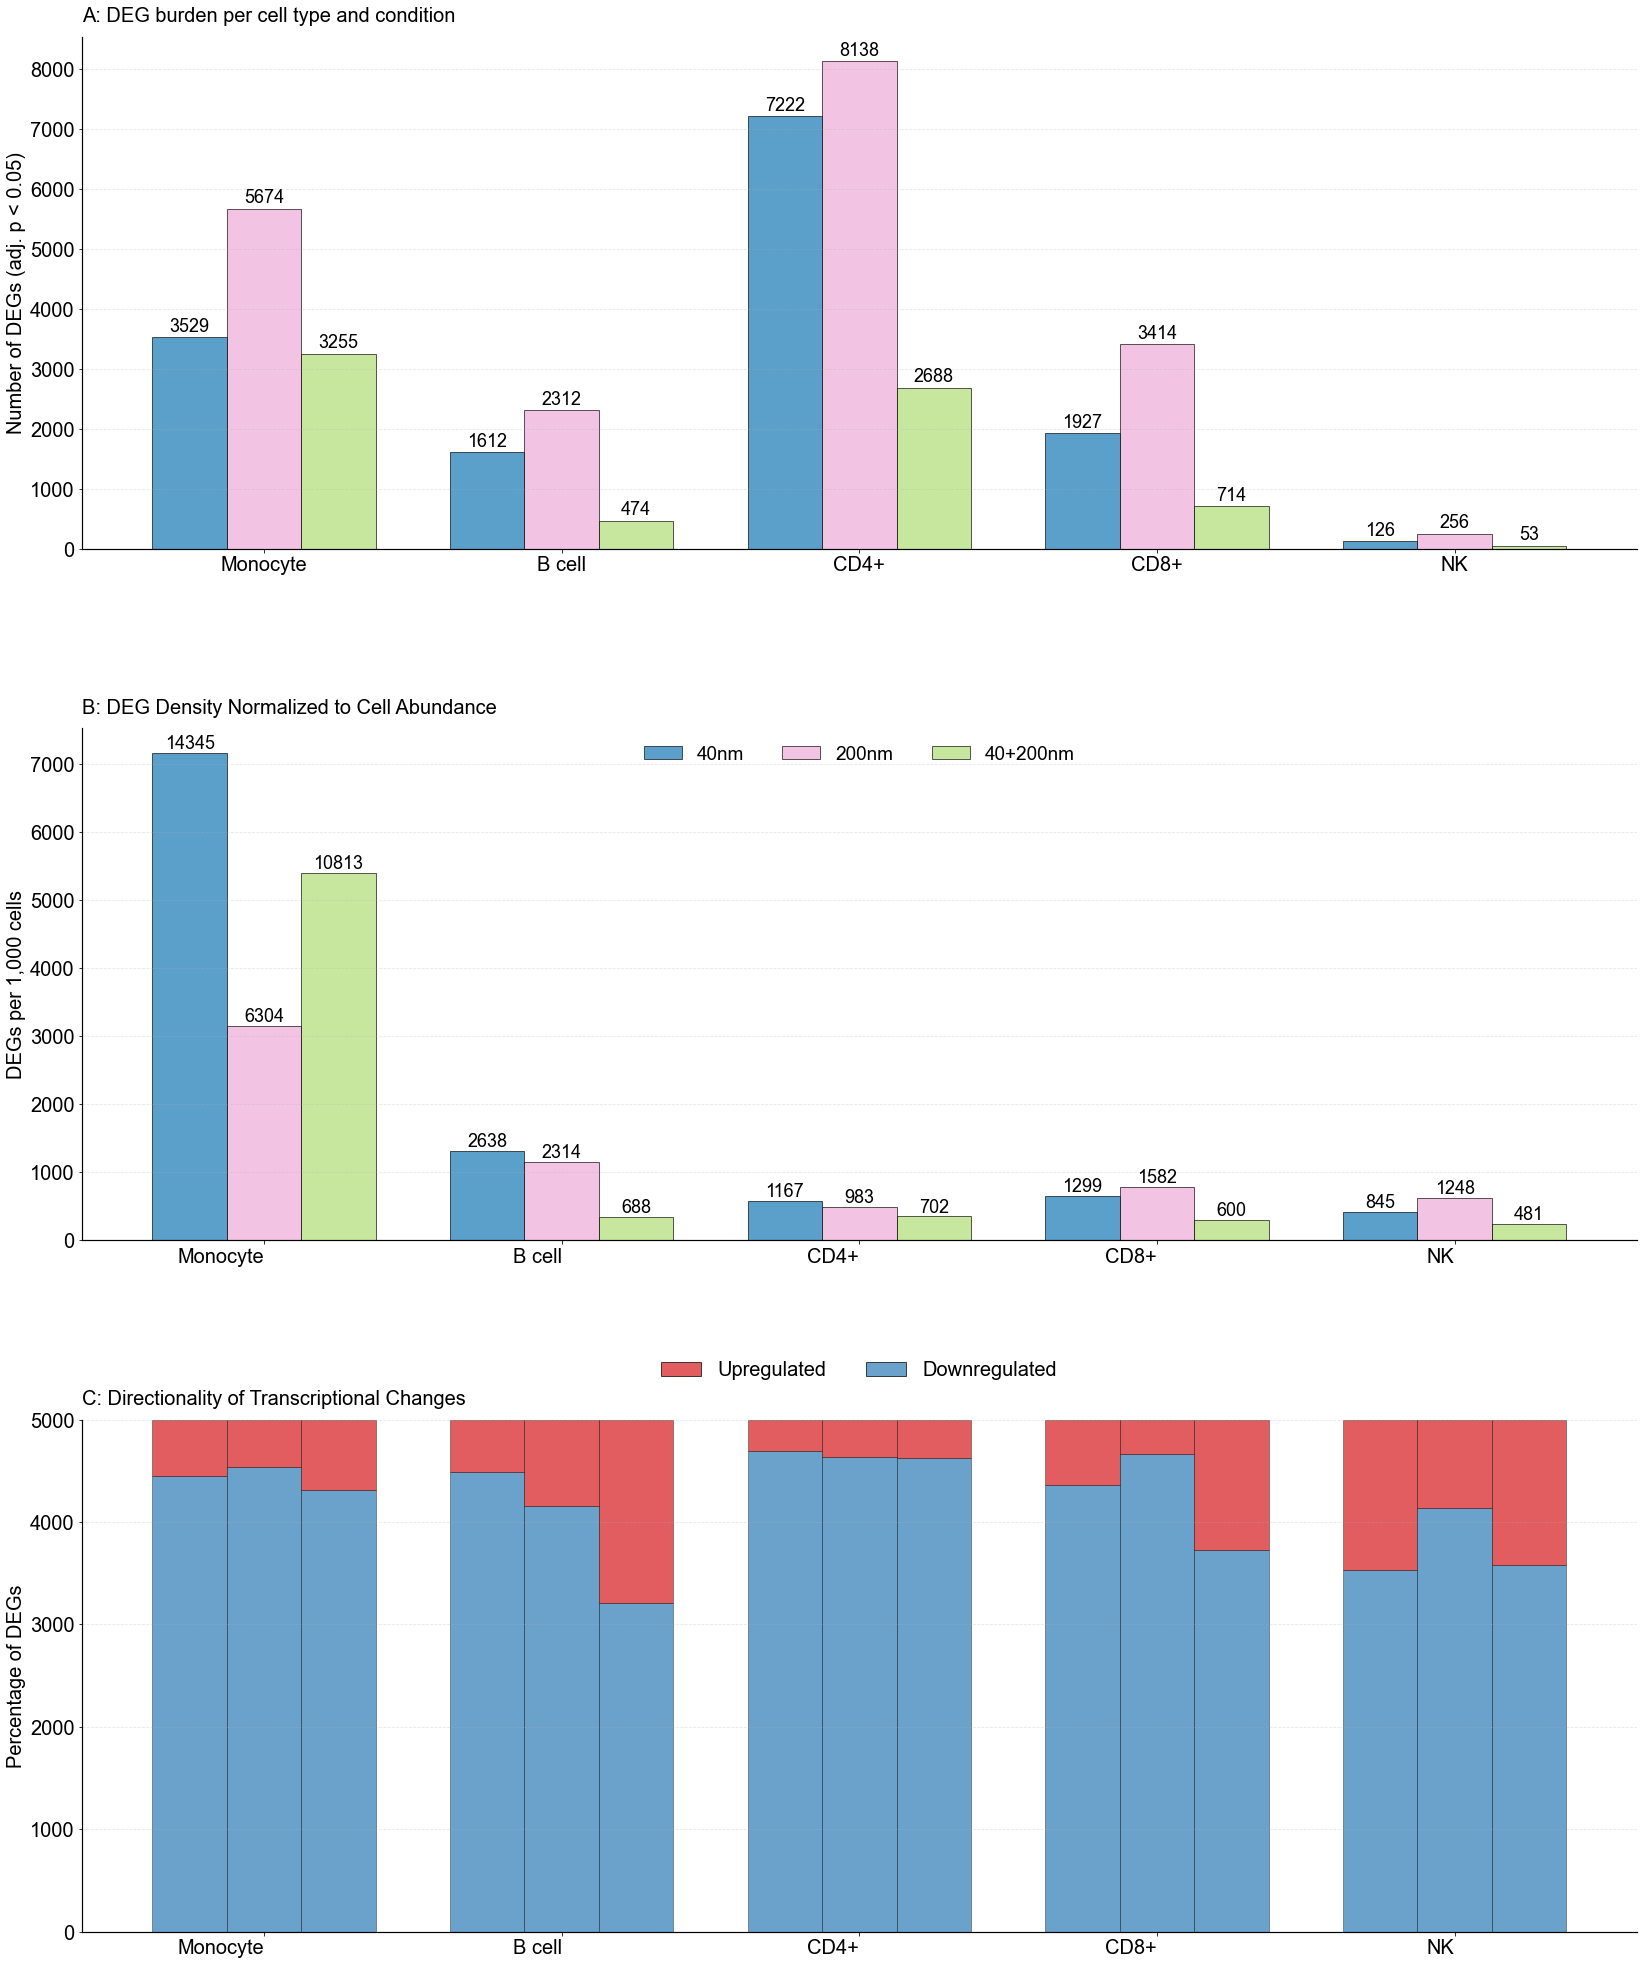

In [6]:
"""
FIGURE 2: Complete - Size-dependent transcriptional impact of PSNP exposure
Updated: 2026-01-08
- Panel 2A: DEG burden per cell type and experimental condition
- Panel 2B: DEG burden normalized to cell abundance (DEG density per 1,000 cells)
- Panel 2C: Directionality of transcriptional changes  
- Panel 2D: Full volcano plots (all cell types × all conditions)
"""
logger.info("Creating Complete Figure 2...")


# Create figure with complex layout
fig = plt.figure(figsize=(24, 28))
gs = GridSpec(3, 1, figure=fig, hspace=0.35, height_ratios=[1, 1, 1],
              left=0.08, right=0.98, top=0.97, bottom=0.03)


# ============================================================
# Panel 2A: DEG Burden per Cell Type
# ============================================================
logger.info("  Panel 2A: DEG Burden...")
ax_2a = fig.add_subplot(gs[0])

deg_data = []
for sample in samples:
    for ct in CELL_TYPE_ORDER:
        sheet_name = get_sheet_name_fig2(ct, sample)
        if sheet_name in de_results:
            n_degs = len(de_results[sheet_name][de_results[sheet_name]['pvals_adj'] < 0.05])
            deg_data.append({'Cell Type': ct, 'Sample': sample, 'DEGs': n_degs})

deg_df = pd.DataFrame(deg_data)
x = np.arange(len(CELL_TYPE_ORDER))
width = 0.25

for i, sample in enumerate(samples):
    sample_data = deg_df[deg_df['Sample'] == sample]
    heights = [sample_data[sample_data['Cell Type'] == ct]['DEGs'].values[0]
               if len(sample_data[sample_data['Cell Type'] == ct]) > 0 else 0
               for ct in CELL_TYPE_ORDER]
    
    bars = ax_2a.bar(x + i*width - width, heights, width, label=sample,
                     color=SAMPLE_COLORS[sample], edgecolor='black', linewidth=0.8, alpha=0.8)
    
    for bar, height in zip(bars, heights):
        if height > 0:
            ax_2a.text(bar.get_x() + bar.get_width()/2, height + 30,
                      str(int(height)), ha='center', va='bottom', fontsize=18)

ax_2a.set_xticks(x)
ax_2a.set_xticklabels([CELL_TYPE_SHORT_MAP[ct] for ct in CELL_TYPE_ORDER], rotation=0, ha='center', fontsize=20)
ax_2a.set_ylabel('Number of DEGs (adj. p < 0.05)', fontsize=20)
ax_2a.set_yticklabels([label.get_text() for label in ax_2a.get_yticklabels()], fontsize=20)
ax_2a.set_title('A: DEG burden per cell type and condition',
               fontsize=20, loc='left', pad=15)
ax_2a.spines['top'].set_visible(False)
ax_2a.spines['right'].set_visible(False)
ax_2a.grid(axis='y', alpha=0.3, linestyle='--')

# ============================================================
# Panel 2B: DEG Density (DEGs per 1,000 cells)
# ============================================================
logger.info("  Panel 2B: DEG Density normalized to cell abundance...")
ax_2b = fig.add_subplot(gs[1])

# Load cell counts
try:
    import scanpy as sc
    adata = sc.read_h5ad('../data/merged_harmony.h5ad')
    cell_counts = {}
    for sample_num, sample_name in [(1, '40nm'), (2, '200nm'), (3, '40+200nm')]:
        sample_mask = adata.obs['sample'] == f'sample_{sample_num}'
        for ct in CELL_TYPE_ORDER:
            ct_mask = adata.obs['CoDi_dist'] == ct
            count = (sample_mask & ct_mask).sum()
            cell_counts[(ct, sample_name)] = count
except Exception as e:
    logger.warning(f"  Error calculating cell counts: {e}")
    assert f"Error calculating cell counts: {e}"

# Calculate DEG density
density_data = []
for sample_name in samples:
    for ct in CELL_TYPE_ORDER:
        deg_count = deg_df[(deg_df['Cell Type'] == ct) & (deg_df['Sample'] == sample_name)]['DEGs'].values
        deg_count = deg_count[0] if len(deg_count) > 0 else 0
        n_cells = cell_counts.get((ct, sample_name), 1)
        deg_density = (deg_count / n_cells) * 1000 if n_cells > 0 else 0
        density_data.append({'Cell Type': ct, 'Sample': sample_name, 'DEG Density': deg_density})

density_df = pd.DataFrame(density_data)

# Plot
for i, sample in enumerate(samples):
    sample_data = density_df[density_df['Sample'] == sample]
    heights = [sample_data[sample_data['Cell Type'] == ct]['DEG Density'].values[0]
               if len(sample_data[sample_data['Cell Type'] == ct]) > 0 else 0
               for ct in CELL_TYPE_ORDER]
    bars = ax_2b.bar(x + i*width - width, heights, width, label=sample,
                     color=SAMPLE_COLORS[sample], edgecolor='black', linewidth=0.8, alpha=0.8)
    
    for bar, height in zip(bars, heights):
        if height > 0:
            ax_2b.text(bar.get_x() + bar.get_width()/2, height + 10,
                      f'{int(height)}', ha='center', va='bottom', fontsize=18)

ax_2b.set_xticks(x)
ax_2b.set_xticklabels([CELL_TYPE_SHORT_MAP[ct] for ct in CELL_TYPE_ORDER], rotation=0, ha='right', fontsize=20)
ax_2b.set_ylabel('DEGs per 1,000 cells', fontsize=20)
ax_2b.set_yticklabels([label.get_text() for label in ax_2a.get_yticklabels()], fontsize=20)
ax_2b.set_title('B: DEG Density Normalized to Cell Abundance',
               fontsize=20, loc='left', pad=15)
ax_2b.legend(frameon=False, fontsize=19, ncol=4, loc='upper center')
ax_2b.spines['top'].set_visible(False)
ax_2b.spines['right'].set_visible(False)
ax_2b.grid(axis='y', alpha=0.3, linestyle='--')

# ============================================================
# Panel 2C: Directionality
# ============================================================
logger.info("  Panel 2C: Directionality...")
ax_2c = fig.add_subplot(gs[2])

direction_data = []
for sample in samples:
    for ct in CELL_TYPE_ORDER:
        sheet_name = get_sheet_name_fig2(ct, sample)
        if sheet_name in de_results:
            df = de_results[sheet_name]
            sig_df = df[df['pvals_adj'] < 0.05]
            n_up = len(sig_df[sig_df['logfoldchanges'] > 0])
            n_down = len(sig_df[sig_df['logfoldchanges'] < 0])
            total = n_up + n_down
            if total > 0:
                direction_data.append({
                    'Cell Type': ct, 'Sample': sample,
                    'Up %': (n_up / total) * 100, 'Down %': (n_down / total) * 100
                })

dir_df = pd.DataFrame(direction_data)

for i, sample in enumerate(samples):
    sample_data = dir_df[dir_df['Sample'] == sample]
    up_vals = [sample_data[sample_data['Cell Type'] == ct]['Up %'].values[0]
               if len(sample_data[sample_data['Cell Type'] == ct]) > 0 else 0
               for ct in CELL_TYPE_ORDER]
    down_vals = [sample_data[sample_data['Cell Type'] == ct]['Down %'].values[0]
                 if len(sample_data[sample_data['Cell Type'] == ct]) > 0 else 0
                 for ct in CELL_TYPE_ORDER]
    pos = x + i*width - width
    ax_2c.bar(pos, down_vals, width, color=REG_COLORS['Downregulated'], 
             edgecolor='black', linewidth=0.5, alpha=0.7)
    ax_2c.bar(pos, up_vals, width, bottom=down_vals, color=REG_COLORS['Upregulated'],
             edgecolor='black', linewidth=0.5, alpha=0.7)

ax_2c.set_xticks(x)
ax_2c.set_xticklabels([CELL_TYPE_SHORT_MAP[ct] for ct in CELL_TYPE_ORDER], rotation=0, ha='right', fontsize=20)
ax_2c.set_ylabel('Percentage of DEGs', fontsize=20)
ax_2c.set_yticklabels([label.get_text() for label in ax_2a.get_yticklabels()], fontsize=20)
ax_2c.set_title('C: Directionality of Transcriptional Changes',
               fontsize=20, loc='left', pad=15)
ax_2c.set_ylim(0, 100)
ax_2c.spines['top'].set_visible(False)
ax_2c.spines['right'].set_visible(False)
ax_2c.grid(axis='y', alpha=0.3, linestyle='--')


ax_2c.legend(
    handles=[
        Patch(facecolor=REG_COLORS['Upregulated'], label='Upregulated',
              edgecolor='black', alpha=0.7),
        Patch(facecolor=REG_COLORS['Downregulated'], label='Downregulated',
              edgecolor='black', alpha=0.7)
    ],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),   # ⬅ above the plot
    ncol=2,                        # side-by-side
    fontsize=20,
    frameon=False
)

# Save
plt.savefig(FIG_DIR / 'Figure_2_complete.pdf', bbox_inches='tight')
logger.info("✓ Figure 2 complete\n")

# ============================================================
# FIGURE 3: 40nm PSNPs - Dominant Transcriptional Programs
# ============================================================

20:31:51 - INFO - Creating Figure 3...
20:31:51 - INFO -   Panel 3A: KEGG pathways heatmap...
20:31:51 - INFO -   Panel 3B: Gene expression heatmap...
20:31:52 - INFO - maxp pruned
20:31:52 - INFO - LTSH dropped
20:31:52 - INFO - cmap pruned
20:31:52 - INFO - kern dropped
20:31:52 - INFO - post pruned
20:31:52 - INFO - PCLT dropped
20:31:52 - INFO - GPOS pruned
20:31:52 - INFO - GSUB pruned
20:31:52 - INFO - JSTF dropped
20:31:52 - INFO - DSIG dropped
20:31:52 - INFO - name pruned
20:31:52 - INFO - glyf pruned
20:31:52 - INFO - Added gid0 to subset
20:31:52 - INFO - Added first four glyphs to subset
20:31:52 - INFO - Closing glyph list over 'GSUB': 24 glyphs before
20:31:52 - INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'G', 'H', 'L', 'M', 'P', 'R', 'S', 'eight', 'four', 'hyphen', 'nine', 'nonmarkingreturn', 'one', 'seven', 'space', 'three', 'two', 'zero']
20:31:52 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 26, 27, 28, 36, 37, 38, 39, 42, 43, 47, 48, 51,

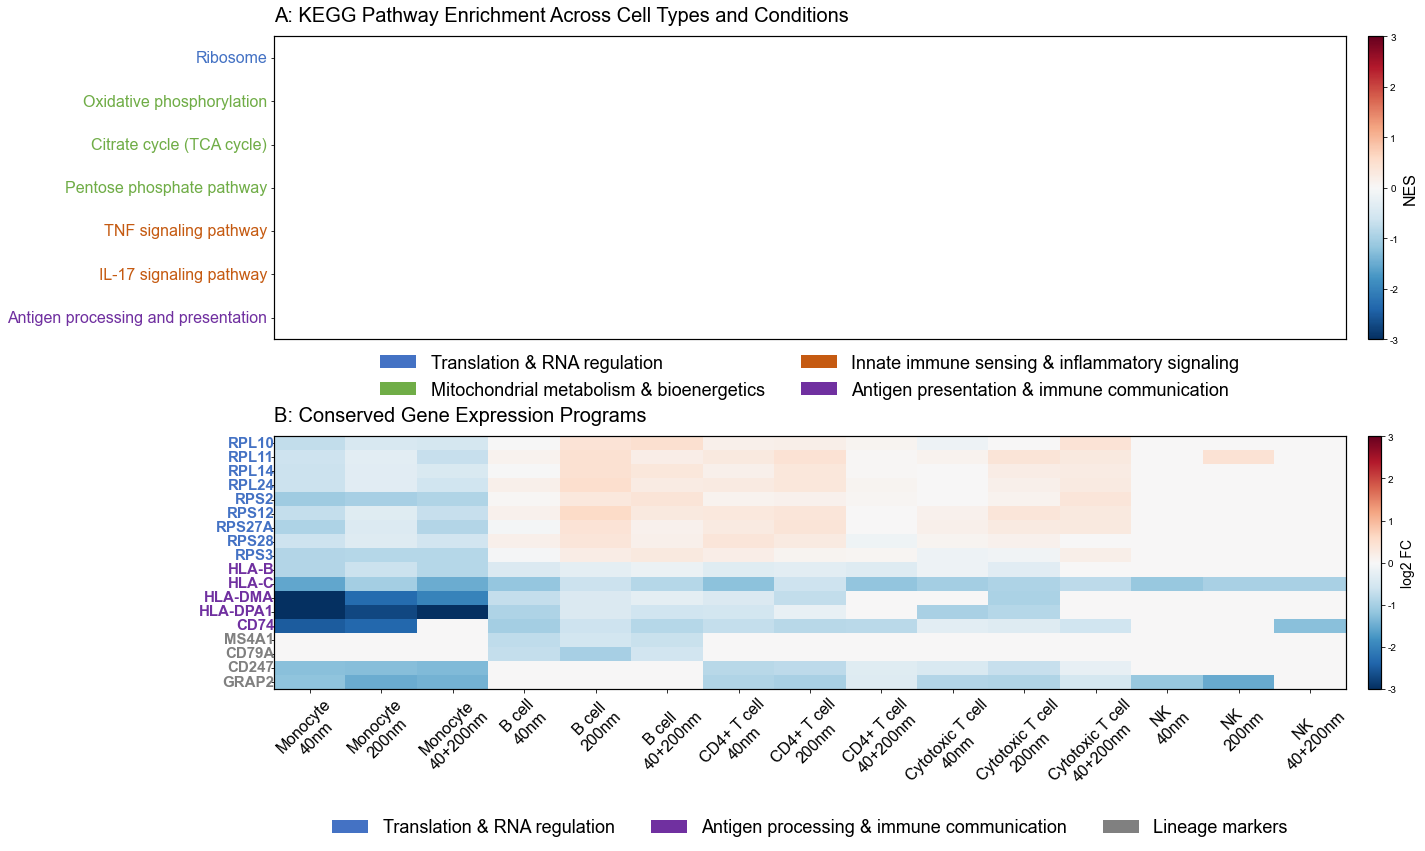

In [7]:
"""
FIGURE 3: Conserved transcriptional programs induced by PSNP exposure
- Panel 3A: KEGG pathways heatmap (Pathway × Cell type × condition)
- Panel 3B: Gene expression heatmap showing conserved programs
"""
logger.info("Creating Figure 3...")

# ============================================================
# Panel 3A: KEGG Pathways Heatmap
# ============================================================
logger.info("  Panel 3A: KEGG pathways heatmap...")

# Define pathways and their groups
pathway_groups = {
    'Translation & RNA regulation': {
        'color': '#4472C4',
        'pathways': ['Ribosome']
    },
    'Mitochondrial metabolism & bioenergetics': {
        'color': '#70AD47',
        'pathways': [
            'Oxidative phosphorylation',
            'Citrate cycle (TCA cycle)',
            'Pentose phosphate pathway'
        ]
    },
    'Innate immune sensing & inflammatory signaling': {
        'color': '#C55A11',
        'pathways': [
            'TNF signaling pathway',
            'IL-17 signaling pathway'
        ]
    },
    'Antigen presentation & immune communication': {
        'color': '#7030A0',
        'pathways': ['Antigen processing and presentation']
    }
}

# Flatten pathway list with colors
pathway_list = []
pathway_colors_dict = {}
for group_name, group_data in pathway_groups.items():
    for pathway in group_data['pathways']:
        pathway_list.append(pathway)
        pathway_colors_dict[pathway] = group_data['color']

# Build NES matrix
nes_data = []
cell_conditions = []

for ct in CELL_TYPE_ORDER:
    for sample in samples:
        ct_map = {
            'B cell': 'Bcell',
            'CD4+ T cell': 'CD4+Tcell',
            'Cytotoxic T cell': 'CytotoxicTcell',
            'CD14+ monocyte': 'CD14+monocyte',
            'Natural killer cell': 'Naturalkillercell'
        }
        cond_map = {'40nm': 'sample_1', '200nm': 'sample_2', '40+200nm': 'sample_3'}
        
        sheet_name = get_gse_sheet_name(ct, sample)
        cell_cond_label = f"{ct.replace('CD14+ monocyte', 'Monocyte').replace('Natural killer cell', 'NK')}\n{sample}"
        cell_conditions.append(cell_cond_label)
        
        nes_values = []
        if sheet_name in gse_results:
            df = gse_results[sheet_name]
            for pathway in pathway_list:
                term_col = 'KEGG Term' if 'KEGG Term' in df.columns else 'Term'
                matches = df[df[term_col] == pathway]
                if len(matches) == 0:
                    matches = df[df[term_col].str.contains(pathway, case=False, na=False, regex=False)]
                if len(matches) > 0:
                    nes = matches.iloc[0]['NES']
                    nes_values.append(nes)
                else:
                    nes_values.append(np.nan)
        else:
            nes_values = [np.nan] * len(pathway_list)
        
        nes_data.append(nes_values)

nes_matrix = np.array(nes_data).T  # Transpose: pathways × cell_conditions

# Create Figure 3
fig3 = plt.figure(figsize=(20, 12))
gs3 = fig3.add_gridspec(2, 1, hspace=0.35, height_ratios=[1.2, 1])

# Panel 3A: Heatmap
ax_3a = fig3.add_subplot(gs3[0])

# Plot heatmap
im = ax_3a.imshow(nes_matrix, cmap=cmap, aspect='auto', vmin=-3, vmax=3)

# Add pathway labels with colors
ax_3a.set_yticks(range(len(pathway_list)))
ytick_labels = []
for i, pathway in enumerate(pathway_list):
    label = ax_3a.text(-0.6, i, f'{pathway}', va='center', ha='right',
                       fontsize=16, color=pathway_colors_dict[pathway])
    ytick_labels.append('')
ax_3a.set_yticklabels(ytick_labels)

# Add cell type/condition labels
ax_3a.set_xticks([])#range(len(cell_conditions)))
ax_3a.set_xticklabels([]) #cell_conditions, rotation=45, ha='center', fontsize=16)

# Colorbar
cbar = plt.colorbar(im, ax=ax_3a, fraction=0.02, pad=0.02)
cbar.set_label('NES', fontsize=16)

ax_3a.set_title('A: KEGG Pathway Enrichment Across Cell Types and Conditions',
               fontsize=20, loc='left', pad=15)

# Add legend for pathway groups
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=group_data['color'], label=group_name)
                   for group_name, group_data in pathway_groups.items()]
ax_3a.legend(handles=legend_elements, loc='lower center', 
             fontsize=18, frameon=False,
             bbox_to_anchor=(0.5, -0.25),   # ⬅ below the plot
             ncol=2)                        # side-by-side)

# ============================================================
# Panel 3B: Gene Expression Heatmap (Conserved Programs)
# ============================================================
logger.info("  Panel 3B: Gene expression heatmap...")

# Define gene blocks
gene_blocks = {
    'Translation & RNA regulation': {
        'genes': ['RPL10', 'RPL11', 'RPL14', 'RPL24', 'RPS2', 'RPS12', 'RPS27A', 'RPS28', 'RPS3'],
        'color': '#4472C4'
    },
    'Antigen processing & immune communication': {
        'genes': ['HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DPA1', 'CD74'],
        'color': '#7030A0'
    },
    'Lineage markers': {
        'genes': ['MS4A1', 'CD79A', 'CD247', 'GRAP2'],
        'color': '#808080'
    }
}

# Get log2FC values
ax_3b = fig3.add_subplot(gs3[1])

gene_list = []
gene_colors_list = []
for block_name, block_data in gene_blocks.items():
    gene_list.extend(block_data['genes'])
    gene_colors_list.extend([block_data['color']] * len(block_data['genes']))

# Build log2FC matrix
log2fc_data = []
for gene in gene_list:
    fc_values = []
    for ct in CELL_TYPE_ORDER:
        for sample in samples:
            sheet_name = get_sheet_name_fig2(ct, sample)
            if sheet_name in de_results:
                df = de_results[sheet_name]
                gene_data = df[df['names'] == gene]
                if len(gene_data) > 0:
                    fc_values.append(gene_data.iloc[0]['logfoldchanges'])
                else:
                    fc_values.append(0)
            else:
                fc_values.append(0)
    log2fc_data.append(fc_values)

log2fc_matrix = np.array(log2fc_data)

# Plot dot plot style
im2 = ax_3b.imshow(log2fc_matrix, cmap=cmap, aspect='auto', vmin=-3, vmax=3)

# Gene labels with colors
ax_3b.set_yticks(range(len(gene_list)))
for i, (gene, color) in enumerate(zip(gene_list, gene_colors_list)):
    ax_3b.text(-0.5, i, gene, va='center', ha='right', fontsize=15,
              color=color, fontweight='bold')
ax_3b.set_yticklabels([])

# Cell type/condition labels
ax_3b.set_xticks(range(len(cell_conditions)))
ax_3b.set_xticklabels(cell_conditions, rotation=45, ha='center', fontsize=16)

# Colorbar
cbar2 = plt.colorbar(im2, ax=ax_3b, fraction=0.02, pad=0.02)
cbar2.set_label('log2 FC', fontsize=14)

ax_3b.set_title('B: Conserved Gene Expression Programs',
               fontsize=20, loc='left', pad=15)

# Add block legend
legend_elements2 = [Patch(facecolor=block_data['color'], label=block_name)
                    for block_name, block_data in gene_blocks.items()]
ax_3b.legend(handles=legend_elements2, loc='lower center',
             fontsize=18, frameon=False,
             bbox_to_anchor=(0.5, -0.65),   # ⬅ below the plot
             ncol=3)

plt.savefig(FIG_DIR / 'Figure_3_conserved_programs.pdf', bbox_inches='tight')
logger.info("✓ Figure 3 complete\n")

# ============================================================
# FIGURE 4: 200nm PSNPs - Broad Transcriptional Perturbation
# ============================================================

20:31:53 - INFO - Creating Figure 4...
20:31:53 - INFO -   Panel 4A: Monocyte volcano plots...
20:31:53 - INFO -   Panel 4B: Module-based gene heatmap...
20:31:53 - INFO -   Panel 4C: Pathway coherence dot plot...
20:31:55 - INFO - maxp pruned
20:31:55 - INFO - LTSH dropped
20:31:55 - INFO - cmap pruned
20:31:55 - INFO - kern dropped
20:31:55 - INFO - post pruned
20:31:55 - INFO - PCLT dropped
20:31:55 - INFO - GPOS pruned
20:31:55 - INFO - GSUB pruned
20:31:55 - INFO - DSIG dropped
20:31:55 - INFO - name pruned
20:31:55 - INFO - glyf pruned
20:31:55 - INFO - Added gid0 to subset
20:31:55 - INFO - Added first four glyphs to subset
20:31:55 - INFO - Closing glyph list over 'GSUB': 44 glyphs before
20:31:55 - INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'G', 'I', 'L', 'M', 'N', 'P', 'R', 'T', 'a', 'ampersand', 'b', 'c', 'colon', 'd', 'e', 'endash', 'f', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'parenleft', 'parenright', 'quotedbl', 'r', 's', 'space

20:31:55 - INFO - post subsetted
20:31:55 - INFO - gasp subsetting not needed
20:31:55 - INFO - GDEF subsetted
20:31:55 - INFO - GPOS subsetted
20:31:55 - INFO - GSUB subsetted
20:31:55 - INFO - name subsetting not needed
20:31:55 - INFO - glyf subsetted
20:31:55 - INFO - head pruned
20:31:55 - INFO - OS/2 Unicode ranges pruned: [0]
20:31:55 - INFO - glyf pruned
20:31:55 - INFO - GDEF pruned
20:31:55 - INFO - GPOS pruned
20:31:55 - INFO - GSUB pruned
20:31:56 - INFO - ✓ Figure 4 complete



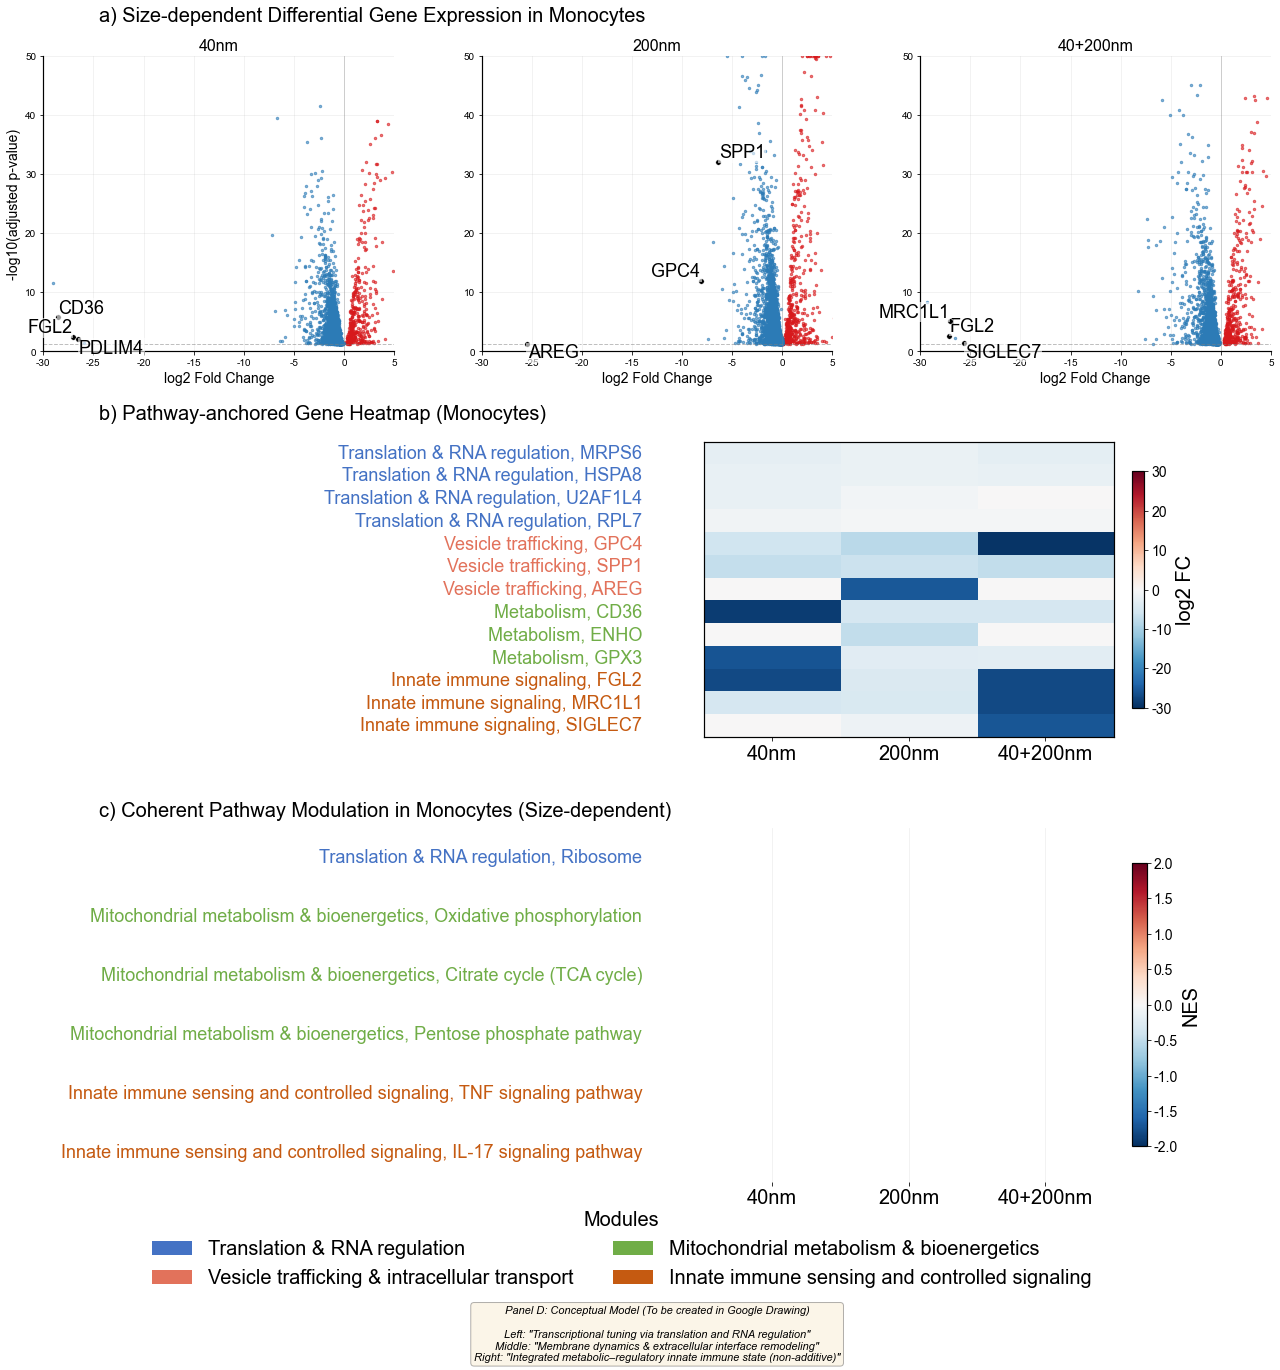

In [8]:
"""
FIGURE 4: Size-dependent transcriptional remodeling in monocytes following PSNP exposure
- Panel 4A: Three volcano plots for monocytes with labeled anchor genes
- Panel 4B: Pathway-anchored gene heatmap showing modules
- Panel 4C: Dot plot showing pathway coherence (modules × conditions)
- Panel 4D: Placeholder for conceptual model (Google Drawing)
"""
logger.info("Creating Figure 4...")

# Create figure
fig4 = plt.figure(figsize=(22, 24))
gs4 = fig4.add_gridspec(4, 1, hspace=0.35, height_ratios=[1, 1, 1.2, 0.3])

# ============================================================
# Panel 4A: Volcano Plots for Monocytes with Labeled Genes
# ============================================================
logger.info("  Panel 4A: Monocyte volcano plots...")

gs_4a = gs4[0].subgridspec(1, 3, wspace=0.25)

# Genes to label for each condition
genes_to_label = {
    '40nm': ['CD36', 'FGL2', 'PDLIM4'],
    '200nm': ['SPP1', 'GPC4', 'AREG'],
    '40+200nm': ['FGL2', 'MRC1L1', 'SIGLEC7']
}

for i, (condition, genes) in enumerate(genes_to_label.items()):
    ax = fig4.add_subplot(gs_4a[0, i])
    
    # Get monocyte data
    sheet_name = get_sheet_name_fig2('CD14+ monocyte', condition)
    
    if sheet_name in de_results:
        df = de_results[sheet_name].copy()
        df['-log10_pval'] = -np.log10(df['pvals_adj'].replace(0, 1e-300))
        
        # Plot all points
        sig_mask = df['pvals_adj'] < 0.05
        up_mask = (df['logfoldchanges'] > 0) & sig_mask
        down_mask = (df['logfoldchanges'] < 0) & sig_mask
        
        ax.scatter(df.loc[~sig_mask, 'logfoldchanges'], df.loc[~sig_mask, '-log10_pval'],
                  c=REG_COLORS['Not Significant'], s=4, alpha=0.3, rasterized=True, zorder=1)
        ax.scatter(df.loc[up_mask, 'logfoldchanges'], df.loc[up_mask, '-log10_pval'],
                  c=REG_COLORS['Upregulated'], s=6, alpha=0.6, rasterized=True, zorder=2)
        ax.scatter(df.loc[down_mask, 'logfoldchanges'], df.loc[down_mask, '-log10_pval'],
                  c=REG_COLORS['Downregulated'], s=6, alpha=0.6, rasterized=True, zorder=2)
        
        # Label anchor genes
        offset = 0.04
        label_positions = [
            {'dx': offset, 'dy': 0.0, 'ha': 'left', 'va': 'center'},
            {'dx': -offset, 'dy': 0.0, 'ha': 'right', 'va': 'center'},
            {'dx': 0.0, 'dy': offset, 'ha': 'center', 'va': 'bottom'},
            {'dx': 0.0, 'dy': -offset, 'ha': 'center', 'va': 'top'},
            {'dx': offset, 'dy': offset, 'ha': 'left', 'va': 'bottom'},
            {'dx': -offset, 'dy': offset, 'ha': 'right', 'va': 'bottom'},
            {'dx': offset, 'dy': -offset, 'ha': 'left', 'va': 'top'},
            {'dx': -offset, 'dy': -offset, 'ha': 'right', 'va': 'top'},
        ]

        for j, gene in enumerate(genes):
            gene_data = df[df['names'] == gene]
            if len(gene_data) > 0:
                x = gene_data.iloc[0]['logfoldchanges']
                y = gene_data.iloc[0]['-log10_pval']
                ax.scatter([x], [y], c='black', s=30, marker='o', zorder=3, 
                           edgecolors='white', linewidths=0.5)
                pos = label_positions[(j + 4) % len(label_positions)]
                ax.text(x + pos['dx'], y + pos['dy'], f'{gene}', 
                        fontsize=18, ha=pos['ha'], va=pos['va'],
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

        ax.axhline(-np.log10(0.05), color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axvline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.4)
        ax.set_xlim(-30, 5)
        ax.set_ylim(0, 50)
    
    ax.set_xlabel('log2 Fold Change', fontsize=14)
    if i == 0:
        ax.set_ylabel('-log10(adjusted p-value)', fontsize=14)
    ax.set_title(f'{condition}', fontsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.2)

# Panel A title - aligned at x=0.08
fig4.text(0.16, 0.9, 'a) Size-dependent Differential Gene Expression in Monocytes',
         fontsize=20, ha='left')

# ============================================================
# Panel 4B: Pathway-anchored Gene Heatmap (Modules)
# ============================================================
HEATMAP_WIDTH_RATIO = 0.25
logger.info("  Panel 4B: Module-based gene heatmap...")

# Define modules and anchor genes
# 1. MRPS6 (logFC: -2.82) - TiO2 - mitohondrijalni ribozomalni protein                                                                                                     
# 2. HSPA8 (logFC: -2.29) - TiO2 - heat shock protein (chaperon)                                                                                                           
# 3. U2AF1L4 (logFC: -2.20) - TiO2+PSNPs - splicing factor                                                                                                                 
# 4. PPP2R2B (logFC: -2.10) - TiO2+PSNPs - protein phosphatase 2 regulatory subunit              
modules = {
    'Translation & RNA regulation': {
        'genes': ['MRPS6', 'HSPA8', 'U2AF1L4', 'RPL7'],
        'color': '#4472C4'
    },
    'Vesicle trafficking': {
        'genes': ['GPC4', 'SPP1', 'AREG'],
        'color': '#E2725B'
    },
    'Metabolism': {
        'genes': ['CD36', 'ENHO', 'GPX3'],
        'color': '#70AD47'
    },
    'Innate immune signaling': {
        'genes': ['FGL2', 'MRC1L1', 'SIGLEC7'],
        'color': '#C55A11'
    }
}

# Build gene list and colors
module_genes = []
module_colors = []
module_labels = []
for module_name, module_data in modules.items():
    for gene in module_data['genes']:
        module_genes.append(gene)
        module_colors.append(module_data['color'])
        module_labels.append(f"{module_name}, {gene}")

# Get log2FC for monocytes across conditions
monocyte_fc_data = []
for gene in module_genes:
    fc_row = []
    for condition in samples:
        sheet_name = get_sheet_name_fig2('CD14+ monocyte', condition)
        if sheet_name in de_results:
            df = de_results[sheet_name]
            gene_data = df[df['names'] == gene]
            if len(gene_data) > 0:
                fc_row.append(gene_data.iloc[0]['logfoldchanges'])
            else:
                fc_row.append(0)
        else:
            fc_row.append(0)
    monocyte_fc_data.append(fc_row)

fc_matrix = np.array(monocyte_fc_data)

# Use subgridspec to position heatmap with labels on left, heatmap in center, colorbar on right
# Adjust ratios to reduce white space - more space for labels, less padding
gs_4b = gs4[1].subgridspec(1, 3, width_ratios=[0.35, HEATMAP_WIDTH_RATIO, 0.05], wspace=0.02)
ax_4b = fig4.add_subplot(gs_4b[0, 1])

# Plot heatmap
im = ax_4b.imshow(fc_matrix, cmap=cmap, aspect='auto', vmin=-30, vmax=30)

# Annotate values
# for i in range(fc_matrix.shape[0]):
#     for j in range(fc_matrix.shape[1]):
#         ax_4b.text(
#             j, i,
#             f"{fc_matrix[i, j]:.1f}",
#             ha="center",
#             va="center",
#             fontsize=18,
#             fontweight='bold',
#             color="white" if abs(fc_matrix[i, j]) > 15 else "black")

# Y-axis: Module and gene labels - minimal spacing
ax_4b.set_yticks([])
ax_4b.tick_params(left=False)
for i, (label, color) in enumerate(zip(module_labels, module_colors)):
    ax_4b.text(-0.15, i, label, va='center', ha='right', fontsize=18,
              color=color, transform=ax_4b.get_yaxis_transform())

# X-axis: Conditions
ax_4b.set_xticks(range(len(samples)))
ax_4b.set_xticklabels(samples, fontsize=20)

# Colorbar - larger size
cbar = plt.colorbar(im, ax=ax_4b, fraction=0.08, pad=0.04, shrink=0.8)
cbar.set_label('log2 FC', fontsize=20)
cbar.ax.tick_params(labelsize=14)

# Panel B title - aligned with panel A at x=0.16
fig4.text(0.16, 0.67, 'b) Pathway-anchored Gene Heatmap (Monocytes)',
         fontsize=20, ha='left')

# ============================================================
# Panel 4C: Dot Plot - Pathway Coherence by Module
# ============================================================
logger.info("  Panel 4C: Pathway coherence dot plot...")

# Define pathways by module
module_pathways = {
    'Translation & RNA regulation': [
        'Ribosome'
    ],
    'Mitochondrial metabolism & bioenergetics': [
         'Oxidative phosphorylation', 'Citrate cycle (TCA cycle)', 'Pentose phosphate pathway'
    ],
    'Innate immune sensing and controlled signaling': [
        'TNF signaling pathway', 'IL-17 signaling pathway'
    ]
}

# Colors for modules
module_colors_dict = {
    'Translation & RNA regulation': '#4472C4',
    'Vesicle trafficking & intracellular transport': '#E2725B',
    'Mitochondrial metabolism & bioenergetics': '#70AD47',
    'Innate immune sensing and controlled signaling': '#C55A11'
}

# Build pathway list with module info
pathway_entries = []
pathway_colors_list = []
for module_name, pathways in module_pathways.items():
    for pathway in pathways:
        pathway_entries.append(f"{module_name}, {pathway}")
        pathway_colors_list.append(module_colors_dict[module_name])

# Get NES values for monocytes
nes_values_4c = []
for module_name, pathways in module_pathways.items():
    for pathway in pathways:
        nes_row = []
        for condition in samples:
            sheet_name = get_gse_sheet_name('CD14+ monocyte', condition)

            if sheet_name in gse_results:
                df = gse_results[sheet_name]

                term_col = 'KEGG Term' if 'KEGG Term' in df.columns else 'Term'
                matches = df[df[term_col] == pathway]
                if len(matches) == 0:
                    matches = df[df[term_col].str.contains(pathway, case=False, na=False, regex=False)]
                if len(matches) > 0:
                    nes_row.append(matches.iloc[0]['NES'])
                else:
                    nes_row.append(np.nan)
            else:
                nes_row.append(np.nan)
        nes_values_4c.append(nes_row)

nes_matrix_4c = np.array(nes_values_4c)

# Use same subgridspec layout as panel B for alignment
gs_4c = gs4[2].subgridspec(1, 3, width_ratios=[0.35, HEATMAP_WIDTH_RATIO, 0.05], wspace=0.02)
ax_4c = fig4.add_subplot(gs_4c[0, 1])

# Plot heatmap
im2 = ax_4c.imshow(nes_matrix_4c, cmap=cmap, aspect='auto', vmin=-2, vmax=2)

# Annotate values with white font
# for i in range(nes_matrix_4c.shape[0]):
#     for j in range(nes_matrix_4c.shape[1]):
#         val = nes_matrix_4c[i, j]
#         if not np.isnan(val):
#             ax_4c.text(
#                 j, i,
#                 f"{val:.2f}",
#                 ha="center",
#                 va="center",
#                 fontsize=18,
#                 color="white",
#                 fontweight='bold')

# Y-axis: Module and pathway labels - minimal spacing
ax_4c.set_yticks([])
ax_4c.tick_params(left=False)
for i, (label, color) in enumerate(zip(pathway_entries, pathway_colors_list)):
    ax_4c.text(-0.15, i, label, va='center', ha='right', fontsize=18,
              color=color, transform=ax_4c.get_yaxis_transform())

# X-axis: Conditions
ax_4c.set_xticks(range(len(samples)))
ax_4c.set_xticklabels(samples, fontsize=20)

# Colorbar - larger size
cbar2 = plt.colorbar(im2, ax=ax_4c, fraction=0.08, pad=0.04, shrink=0.8)
cbar2.set_label('NES', fontsize=20)
cbar2.ax.tick_params(labelsize=14)

# Panel C title - aligned with panels A and B at x=0.08
fig4.text(0.16, 0.44, 'c) Coherent Pathway Modulation in Monocytes (Size-dependent)',
         fontsize=20, ha='left')

ax_4c.grid(True, alpha=0.2)
for spine in ax_4c.spines.values():
    spine.set_visible(False)

# Legend
legend_elements = [Patch(facecolor=color, label=module) 
                   for module, color in module_colors_dict.items()]
ax_4c.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(-0.2, -0.35),
            fontsize=20, frameon=False, title='Modules', ncol=2, title_fontsize=20)

# ============================================================
# Panel 4D: Placeholder for Google Drawing
# ============================================================
ax_4d = fig4.add_subplot(gs4[3])
ax_4d.text(0.5, 0.3, 
          'Panel D: Conceptual Model (To be created in Google Drawing)\n\n' +
          'Left: "Transcriptional tuning via translation and RNA regulation"\n' +
          'Middle: "Membrane dynamics & extracellular interface remodeling"\n' +
          'Right: "Integrated metabolic–regulatory innate immune state (non-additive)"',
          ha='center', va='center', fontsize=11, style='italic',
          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
ax_4d.axis('off')

plt.savefig(FIG_DIR / 'Figure_4_monocyte_remodeling.pdf', bbox_inches='tight')
logger.info("✓ Figure 4 complete\n")

# ============================================================
# FIGURE 5: Adaptive Immune Cells - Restrained and Lineage-specific Responses
# ============================================================
 
 Figure 5 demonstrates that B cells and CD4+ T cells exhibit transcriptional 
 responses that are more restrained and lineage-specific compared to innate cells.
 
 Panel 5A: DEG burden in adaptive immune cells (B cells, CD4+ T cells) across conditions
 Panel 5B: Lineage-specific gene modulation (MS4A1, CD79A, CD74, CCR7, LTB, RPL7, RPS6)
 Panel 5C: Pathway enrichment showing limited coherence in adaptive cells

20:31:56 - INFO - Creating Figure 5...
20:31:56 - INFO -   Panel 5a: Adaptive immune cell volcano plots...
20:31:57 - INFO -   Panel 5b: Adaptive immunity gene heatmap...
20:31:59 - INFO - maxp pruned
20:31:59 - INFO - LTSH dropped
20:31:59 - INFO - cmap pruned
20:31:59 - INFO - kern dropped
20:31:59 - INFO - post pruned
20:31:59 - INFO - PCLT dropped
20:31:59 - INFO - GPOS pruned
20:31:59 - INFO - GSUB pruned
20:31:59 - INFO - JSTF dropped
20:31:59 - INFO - DSIG dropped
20:31:59 - INFO - name pruned
20:31:59 - INFO - glyf pruned
20:31:59 - INFO - Added gid0 to subset
20:31:59 - INFO - Added first four glyphs to subset
20:31:59 - INFO - Closing glyph list over 'GSUB': 60 glyphs before
20:31:59 - INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'a', 'ampersand', 'b', 'c', 'comma', 'd', 'e', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'j', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenlef

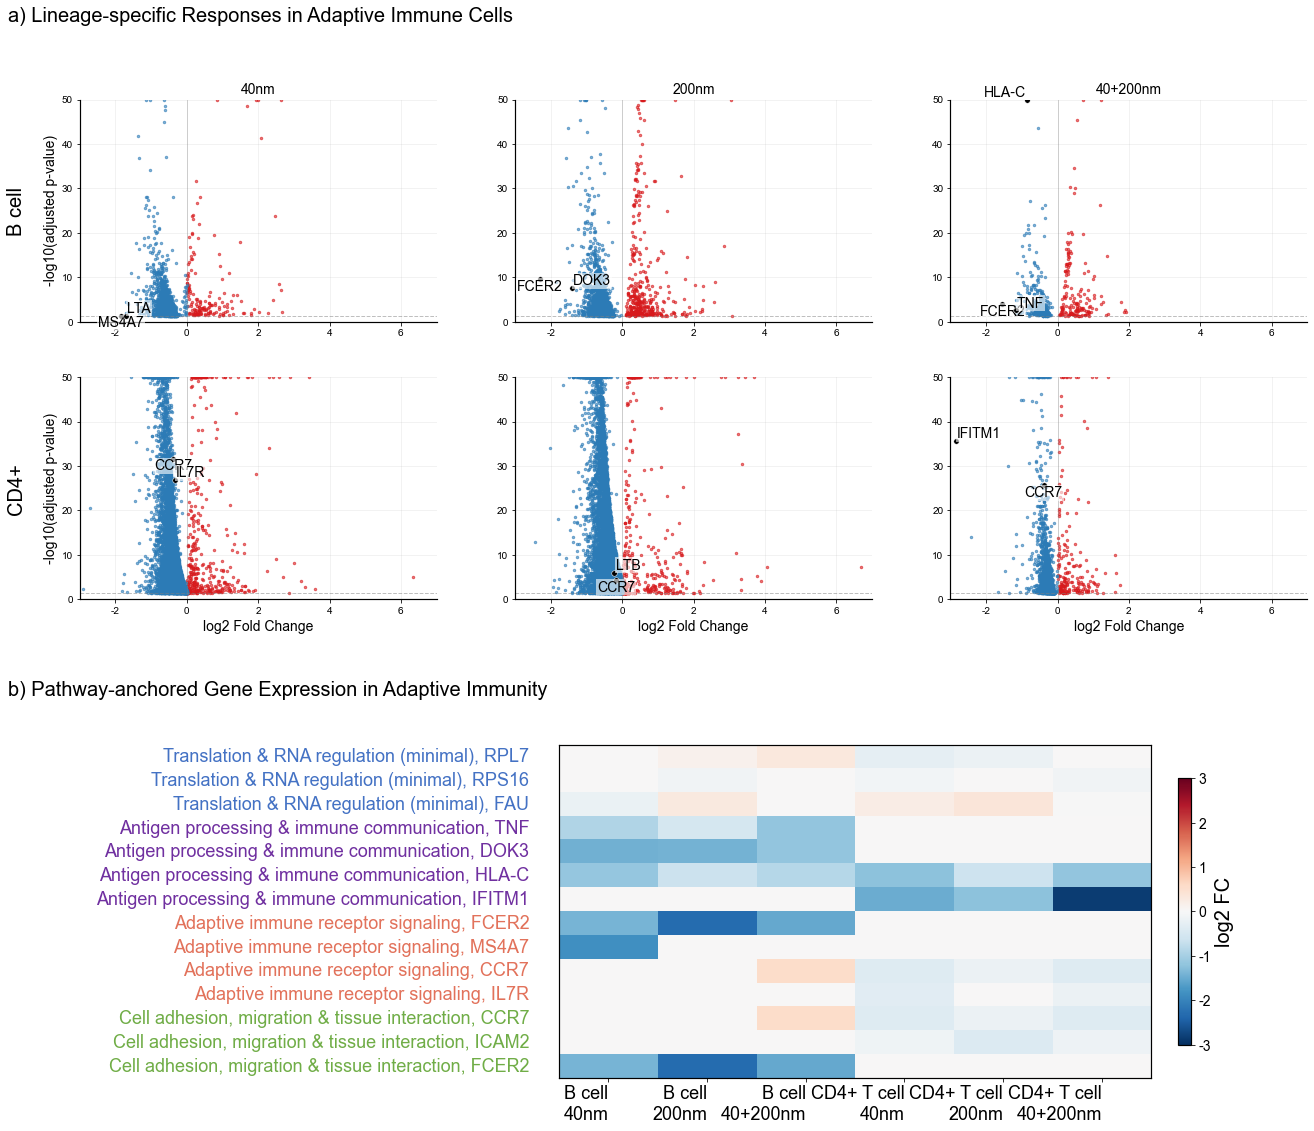

In [9]:
"""
FIGURE 5: Adaptive immune cells display restrained and lineage-specific responses
- Panel 5A: Volcano plots for B cells and CD4+ T cells (3 conditions each)
- Panel 5B: Pathway-anchored heatmap showing adaptive immunity modules
"""
logger.info("Creating Figure 5...")

# Create figure
fig5 = plt.figure(figsize=(22, 18))
gs5 = fig5.add_gridspec(2, 1, hspace=0.35, height_ratios=[1.5, 1])

# ============================================================
# Panel 5A: Volcano Plots for Adaptive Immune Cells
# ============================================================
logger.info("  Panel 5a: Adaptive immune cell volcano plots...")

gs_5a = gs5[0].subgridspec(2, 3, hspace=0.25, wspace=0.22)

# Genes to label for B cells and CD4+ T cells
adaptive_genes_to_label = {
    'B cell': {
        '40nm': ['MS4A7', 'LTA'],
        '200nm': ['FCER2', 'DOK3'],
        '40+200nm': ['FCER2', 'TNF', 'HLA-C']
    },
    'CD4+ T cell': {
        '40nm': ['CCR7', 'IL7R'],
        '200nm': ['CCR7', 'LTB'],
        '40+200nm': ['CCR7', 'IFITM1']
    }
}

cell_types_adaptive = ['B cell', 'CD4+ T cell']

for i, cell_type in enumerate(cell_types_adaptive):
    for j, condition in enumerate(samples):
        ax = fig5.add_subplot(gs_5a[i, j])
        
        sheet_name = get_sheet_name_fig2(cell_type, condition)
        genes = adaptive_genes_to_label[cell_type][condition]
        
        if sheet_name in de_results:
            df = de_results[sheet_name].copy()
            df['-log10_pval'] = -np.log10(df['pvals_adj'].replace(0, 1e-300))

            # Plot all points
            sig_mask = df['pvals_adj'] < 0.05
            up_mask = (df['logfoldchanges'] > 0) & sig_mask
            down_mask = (df['logfoldchanges'] < 0) & sig_mask

            ax.scatter(df.loc[~sig_mask, 'logfoldchanges'], df.loc[~sig_mask, '-log10_pval'],
                      c=REG_COLORS['Not Significant'], s=4, alpha=0.3, rasterized=True, zorder=1)
            ax.scatter(df.loc[up_mask, 'logfoldchanges'], df.loc[up_mask, '-log10_pval'],
                      c=REG_COLORS['Upregulated'], s=6, alpha=0.6, rasterized=True, zorder=2)
            ax.scatter(df.loc[down_mask, 'logfoldchanges'], df.loc[down_mask, '-log10_pval'],
                      c=REG_COLORS['Downregulated'], s=6, alpha=0.6, rasterized=True, zorder=2)

            # Label anchor genes
            offset = 0.04
            label_positions = [
                {'dx': offset, 'dy': 0.0, 'ha': 'left', 'va': 'center'},
                {'dx': -offset, 'dy': 0.0, 'ha': 'right', 'va': 'center'},
                {'dx': 0.0, 'dy': offset, 'ha': 'center', 'va': 'bottom'},
                {'dx': 0.0, 'dy': -offset, 'ha': 'center', 'va': 'top'},
                {'dx': offset, 'dy': offset, 'ha': 'left', 'va': 'bottom'},
                {'dx': -offset, 'dy': offset, 'ha': 'right', 'va': 'bottom'},
                {'dx': offset, 'dy': -offset, 'ha': 'left', 'va': 'top'},
                {'dx': -offset, 'dy': -offset, 'ha': 'right', 'va': 'top'},
            ]

            for k, gene in enumerate(genes):
                gene_data = df[df['names'] == gene]
                if len(gene_data) > 0:
                    x = gene_data.iloc[0]['logfoldchanges']
                    y = gene_data.iloc[0]['-log10_pval']
                    ax.scatter([x], [y], c='black', s=30, marker='o', zorder=3, 
                               edgecolors='white', linewidths=0.5)
                    pos = label_positions[(k + 3) % len(label_positions)]
                    ax.text(x + pos['dx'], y + pos['dy'], f'{gene}', 
                            fontsize=14, ha=pos['ha'], va=pos['va'],
                            bbox=dict(facecolor='w', alpha=0.6, edgecolor='none', pad=1))

            ax.axhline(-np.log10(0.05), color='gray', linestyle='--', linewidth=1, alpha=0.5)
            ax.axvline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.4)
            ax.set_xlim(-3, 7)
            ax.set_ylim(0, 50)
        
        if i == 1:
            ax.set_xlabel('log2 Fold Change', fontsize=14)
        if j == 0:
            ax.set_ylabel('-log10(adjusted p-value)', fontsize=14)
        if i == 0:
            ax.set_title(f'{condition}', fontsize=14)
        if j == 0:
            ax.text(-0.15, 0.5, cell_type.replace(' T cell',''), transform=ax.transAxes,
                   rotation=90, va='center', ha='right', fontsize=20)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, alpha=0.2)

# Panel a title - aligned at x=0.08
fig5.text(0.08, 0.94, 'a) Lineage-specific Responses in Adaptive Immune Cells',
         fontsize=20, ha='left')

# ============================================================
# Panel 5B: Pathway-anchored Heatmap (Adaptive Immunity)
# ============================================================
logger.info("  Panel 5b: Adaptive immunity gene heatmap...")

# Define modules for adaptive immunity
adaptive_modules = {
    'Translation & RNA regulation (minimal)': {
        'genes': ['RPL7', 'RPS16', 'FAU'],
        'color': '#4472C4'
    },
    'Antigen processing & immune communication': {
        'genes': ['TNF', 'DOK3', 'HLA-C', 'IFITM1'],
        'color': '#7030A0'
    },
    'Adaptive immune receptor signaling': {
        'genes': ['FCER2', 'MS4A7', 'CCR7', 'IL7R'],
        'color': '#E2725B'
    },
    'Cell adhesion, migration & tissue interaction': {
        'genes': ['CCR7', 'ICAM2', 'FCER2'],
        'color': '#70AD47'
    }
}

# Build gene list
adaptive_gene_list = []
adaptive_gene_colors = []
adaptive_gene_labels = []
for module_name, module_data in adaptive_modules.items():
    for gene in module_data['genes']:
        adaptive_gene_list.append(gene)
        adaptive_gene_colors.append(module_data['color'])
        adaptive_gene_labels.append(f"{module_name}, {gene}")

# Get log2FC for B cells and CD4+ T cells
adaptive_fc_data = []
adaptive_conditions = []

for cell_type in cell_types_adaptive:
    for condition in samples:
        adaptive_conditions.append(f"{cell_type}\n{condition}")

for gene in adaptive_gene_list:
    fc_row = []
    for cell_type in cell_types_adaptive:
        for condition in samples:
            sheet_name = get_sheet_name_fig2(cell_type, condition)
            if sheet_name in de_results:
                df = de_results[sheet_name]
                gene_data = df[df['names'] == gene]
                if len(gene_data) > 0:
                    fc_row.append(gene_data.iloc[0]['logfoldchanges'])
                else:
                    fc_row.append(0)
            else:
                fc_row.append(0)
    adaptive_fc_data.append(fc_row)

adaptive_fc_matrix = np.array(adaptive_fc_data)

# Use subgridspec to control heatmap width - align with panel a
HEATMAP_WIDTH_RATIO_FIG5 = 0.5
gs_5b = gs5[1].subgridspec(1, 3, width_ratios=[0.35, HEATMAP_WIDTH_RATIO_FIG5, 0.05], wspace=0.02)
ax_5b = fig5.add_subplot(gs_5b[0, 1])

# Plot heatmap
im = ax_5b.imshow(adaptive_fc_matrix, cmap=cmap, aspect='auto', vmin=-3, vmax=3)

# Y-axis: Remove yticks, add labels with minimal spacing
ax_5b.set_yticks([])
ax_5b.tick_params(left=False)
for i, (label, color) in enumerate(zip(adaptive_gene_labels, adaptive_gene_colors)):
    ax_5b.text(-0.05, i, label, va='center', ha='right', fontsize=18,
              color=color, transform=ax_5b.get_yaxis_transform())

# X-axis labels
ax_5b.set_xticks(range(len(adaptive_conditions)))
ax_5b.set_xticklabels(adaptive_conditions, rotation=0, ha='right', fontsize=18)

# Colorbar - larger size
cbar = plt.colorbar(im, ax=ax_5b, fraction=0.08, pad=0.04, shrink=0.8)
cbar.set_label('log2 FC', fontsize=20)
cbar.ax.tick_params(labelsize=14)

# Panel b title - aligned with panel a at x=0.08
fig5.text(0.08, 0.42, 'b) Pathway-anchored Gene Expression in Adaptive Immunity',
         fontsize=20, ha='left')

# Module legend
# legend_elements = [Patch(facecolor=module_data['color'], label=module_name)
#                    for module_name, module_data in adaptive_modules.items()]
# ax_5b.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.05, -0.36),
#             fontsize=18, frameon=True, ncol=2)

plt.savefig(FIG_DIR / 'Figure_5_adaptive_immunity.pdf', bbox_inches='tight')
logger.info("✓ Figure 5 complete\n")

# ============================================================
# FIGURE 6: Integrative Principles of Immune Transcriptional Organization
# ============================================================

20:32:00 - INFO - Creating Figure 6...
20:32:00 - INFO -   Panel 6A: Cross-cell-type dot plot...
20:32:00 - WARNING -   Could not load expression data for % expressing
20:32:00 - INFO -   Panel 6B: Schematic comparison...
20:32:00 - INFO -   Panel 6C: Conceptual model placeholder...
20:32:00 - INFO - maxp pruned
20:32:00 - INFO - LTSH dropped
20:32:00 - INFO - cmap pruned
20:32:00 - INFO - kern dropped
20:32:00 - INFO - post pruned
20:32:00 - INFO - PCLT dropped
20:32:00 - INFO - GPOS pruned
20:32:00 - INFO - GSUB pruned
20:32:00 - INFO - JSTF dropped
20:32:00 - INFO - DSIG dropped
20:32:00 - INFO - name pruned
20:32:00 - INFO - glyf pruned
20:32:00 - INFO - Added gid0 to subset
20:32:00 - INFO - Added first four glyphs to subset
20:32:00 - INFO - Closing glyph list over 'GSUB': 34 glyphs before
20:32:00 - INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'G', 'I', 'L', 'R', 'S', 'a', 'c', 'colon', 'd', 'e', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'p

20:32:01 - INFO - DSIG dropped
20:32:01 - INFO - name pruned
20:32:01 - INFO - glyf pruned
20:32:01 - INFO - Added gid0 to subset
20:32:01 - INFO - Added first four glyphs to subset
20:32:01 - INFO - Closing glyph list over 'GSUB': 48 glyphs before
20:32:01 - INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'U', 'a', 'c', 'd', 'e', 'four', 'g', 'hyphen', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'plus', 'r', 'seven', 'six', 'slash', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'y']
20:32:01 - INFO - Glyph IDs:   [0, 1, 2, 3, 11, 12, 14, 16, 18, 20, 21, 22, 23, 25, 26, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 56, 68, 70, 71, 72, 74, 76, 79, 81, 82, 83, 85, 87, 88, 89, 90, 92]
20:32:01 - INFO - Closed glyph list over 'GSUB': 48 glyphs after
20:32:01 - INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P

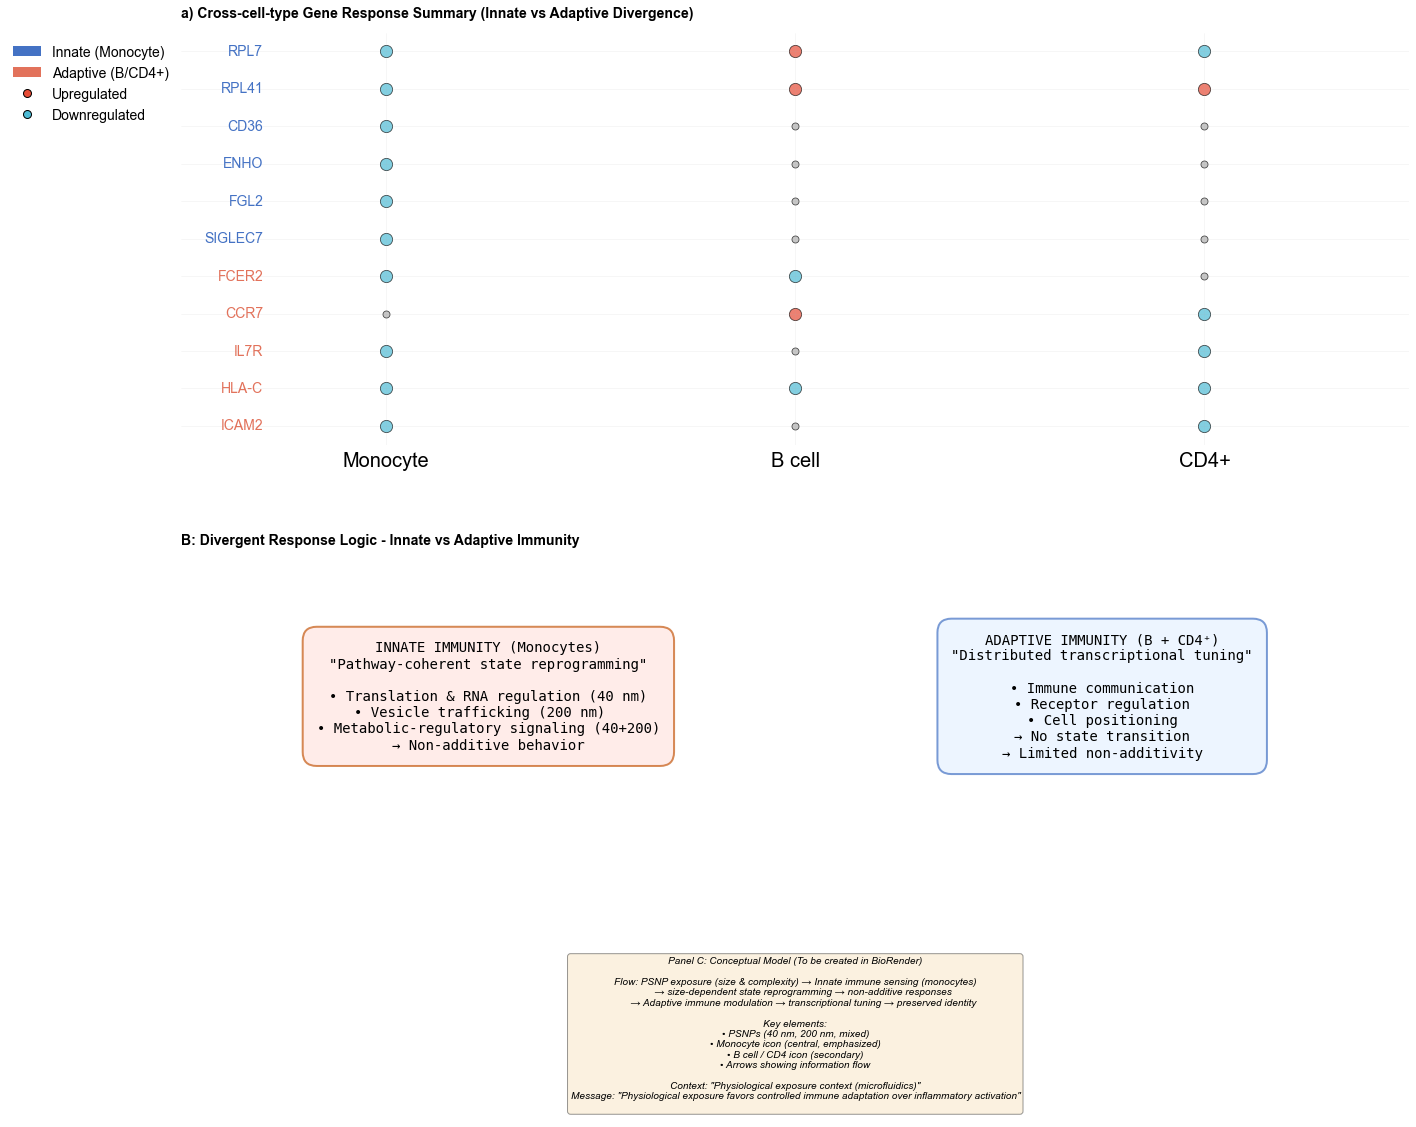

In [10]:
"""
FIGURE 6: Innate vs adaptive immune divergence under PSNP exposure
- Panel 6A: Cross-cell-type gene response summary (dot plot)
- Panel 6B: State coherence vs transcriptional modulation (schematic)
- Panel 6C: Conceptual model (placeholder for BioRender)
"""
logger.info("Creating Figure 6...")

# Create figure
fig6 = plt.figure(figsize=(22, 20))
gs6 = fig6.add_gridspec(3, 1, hspace=0.40, height_ratios=[1.2, 0.8, 0.5])

# ============================================================
# Panel 6A: Cross-cell-type Gene Response Summary
# ============================================================
logger.info("  Panel 6A: Cross-cell-type dot plot...")

ax_6a = fig6.add_subplot(gs6[0])

# Define innate and adaptive anchor genes
innate_genes = {
    'genes': ['RPL7', 'RPL41', 'CD36', 'ENHO', 'FGL2', 'SIGLEC7'],
    'color': '#4472C4',
    'label': 'Innate (Monocyte)'
}

adaptive_genes = {
    'genes': ['FCER2', 'CCR7', 'IL7R', 'HLA-C', 'ICAM2'],
    'color': '#E2725B',
    'label': 'Adaptive (B/CD4+)'
}

# Cell types to compare
cell_types_6a = ['CD14+ monocyte', 'B cell', 'CD4+ T cell']

# Collect gene list
gene_list_6a = innate_genes['genes'] + adaptive_genes['genes']
gene_colors_6a = [innate_genes['color']] * len(innate_genes['genes']) + \
                  [adaptive_genes['color']] * len(adaptive_genes['genes'])

# Load expression data from h5ad for % expressing calculation
try:
    adata = sc.read_h5ad('./merged_harmony.h5ad')
    has_expression_data = True
except:
    has_expression_data = False
    logger.warning("  Could not load expression data for % expressing")

# Get log2FC and expression percentage for each gene × cell type
dot_plot_data = []

for gene in gene_list_6a:
    for cell_type in cell_types_6a:
        # Get average log2FC across conditions
        fc_values = []
        for condition in samples:
            sheet_name = get_sheet_name_fig2(cell_type, condition)
            if sheet_name in de_results:
                df = de_results[sheet_name]
                gene_data = df[df['names'] == gene]
                if len(gene_data) > 0:
                    fc_values.append(gene_data.iloc[0]['logfoldchanges'])
        
        avg_fc = np.mean(fc_values) if fc_values else 0
        
        # Calculate % expressing
        if has_expression_data and gene in adata.var_names:
            cell_mask = adata.obs['cell_type'] == cell_type
            gene_idx = adata.var_names.tolist().index(gene)
            expressing = (adata.X[cell_mask, gene_idx] > 0).sum()
            total = cell_mask.sum()
            pct_expressing = (expressing / total * 100) if total > 0 else 0
        else:
            # Estimate based on significance
            pct_expressing = 30 if avg_fc != 0 else 10
        
        dot_plot_data.append({
            'gene': gene,
            'cell_type': cell_type,
            'avg_fc': avg_fc,
            'pct_expressing': pct_expressing
        })

# Create dot plot
y_pos = {}
for i, gene in enumerate(gene_list_6a):
    y_pos[gene] = i

x_pos = {ct: i for i, ct in enumerate(cell_types_6a)}

for entry in dot_plot_data:
    gene = entry['gene']
    ct = entry['cell_type']
    fc = entry['avg_fc']
    pct = entry['pct_expressing']
    
    x = x_pos[ct]
    y = y_pos[gene]
    
    # Size based on % expressing
    size = pct * 5
    
    # Color based on avg_fc
    if fc > 0:
        color = '#E64B35'  # Red for up
    elif fc < 0:
        color = '#4DBBD5'  # Blue for down
    else:
        color = '#B0B0B0'  # Gray for no change
    
    ax_6a.scatter(x, y, s=size, c=[color], alpha=0.7, edgecolors='black', linewidths=0.8)

# Gene labels with colors
ax_6a.set_yticks(range(len(gene_list_6a)))
for i, (gene, color) in enumerate(zip(gene_list_6a, gene_colors_6a)):
    ax_6a.text(-0.3, i, gene, va='center', ha='right', fontsize=14,
              color=color)
ax_6a.set_yticklabels([])

# Cell type labels
ax_6a.set_xticks(range(len(cell_types_6a)))

ax_6a.set_xticklabels([CELL_TYPE_SHORT_MAP[ct] for ct in cell_types_6a],
                      fontsize=20)
ax_6a.tick_params(axis='x', bottom=False)
ax_6a.tick_params(axis='y', left=False)

ax_6a.set_title('a) Cross-cell-type Gene Response Summary (Innate vs Adaptive Divergence)',
               fontsize=14, fontweight='bold', loc='left', pad=15)
ax_6a.set_xlim(-0.5, len(cell_types_6a) - 0.5)
ax_6a.set_ylim(-0.5, len(gene_list_6a) - 0.5)
ax_6a.grid(True, alpha=0.2, linewidth=0.5)
ax_6a.spines['top'].set_visible(False)
ax_6a.spines['right'].set_visible(False)
ax_6a.spines['bottom'].set_visible(False)
ax_6a.spines['left'].set_visible(False)
ax_6a.invert_yaxis()

# Legend
legend_elements = [
    Patch(facecolor=innate_genes['color'], label=innate_genes['label']),
    Patch(facecolor=adaptive_genes['color'], label=adaptive_genes['label']),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#E64B35',
               markersize=8, label='Upregulated', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4DBBD5',
               markersize=8, label='Downregulated', markeredgecolor='black')
]
ax_6a.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0, 1),
            fontsize=14, frameon=False)

# ============================================================
# Panel 6B: State Coherence vs Transcriptional Modulation
# ============================================================
logger.info("  Panel 6B: Schematic comparison...")

ax_6b = fig6.add_subplot(gs6[1])
ax_6b.axis('off')

# Create side-by-side comparison
left_text = """INNATE IMMUNITY (Monocytes)
"Pathway-coherent state reprogramming"

• Translation & RNA regulation (40 nm)
• Vesicle trafficking (200 nm)  
• Metabolic-regulatory signaling (40+200)
→ Non-additive behavior"""

right_text = """ADAPTIVE IMMUNITY (B + CD4⁺)
"Distributed transcriptional tuning"

• Immune communication
• Receptor regulation
• Cell positioning
→ No state transition
→ Limited non-additivity"""

ax_6b.text(0.25, 0.5, left_text, ha='center', va='center', fontsize=14,
          bbox=dict(boxstyle='round,pad=1', facecolor='#FFE4E1', alpha=0.7, edgecolor='#C55A11', linewidth=2),
          family='monospace')

ax_6b.text(0.75, 0.5, right_text, ha='center', va='center', fontsize=14,
          bbox=dict(boxstyle='round,pad=1', facecolor='#E6F2FF', alpha=0.7, edgecolor='#4472C4', linewidth=2),
          family='monospace')

ax_6b.set_xlim(0, 1)
ax_6b.set_ylim(0, 1)
ax_6b.set_title('B: Divergent Response Logic - Innate vs Adaptive Immunity',
               fontsize=14, fontweight='bold', loc='left', pad=15)

# ============================================================
# Panel 6C: Conceptual Model Placeholder
# ============================================================
logger.info("  Panel 6C: Conceptual model placeholder...")

ax_6c = fig6.add_subplot(gs6[2])
ax_6c.axis('off')

conceptual_text = """Panel C: Conceptual Model (To be created in BioRender)

Flow: PSNP exposure (size & complexity) → Innate immune sensing (monocytes)
      → size-dependent state reprogramming → non-additive responses
      → Adaptive immune modulation → transcriptional tuning → preserved identity

Key elements:
• PSNPs (40 nm, 200 nm, mixed)
• Monocyte icon (central, emphasized)
• B cell / CD4 icon (secondary)
• Arrows showing information flow

Context: "Physiological exposure context (microfluidics)"
Message: "Physiological exposure favors controlled immune adaptation over inflammatory activation"
"""

ax_6c.text(0.5, 0.5, conceptual_text, ha='center', va='center', fontsize=10,
          style='italic', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.4))
ax_6c.set_xlim(0, 1)
ax_6c.set_ylim(0, 1)


plt.savefig(FIG_DIR / 'Figure_6_innate_vs_adaptive.pdf', bbox_inches='tight')
logger.info("✓ Figure 6 complete\n")

# ============================================================
# SUPPLEMENTARY FIGURES
# ============================================================

In [11]:
# ============================================================================
# SUPPLEMENTARY FIGURE S1: BATCH EFFECT METRICS FUNCTIONS
# ============================================================================
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy import stats

def calculate_silhouette_score(embedding, labels):
    """Calculate silhouette score for batch labels (lower = better mixing)."""
    return silhouette_score(embedding, labels)

def calculate_lisi(embedding, labels, perplexity=30):
    """
    Calculate Local Inverse Simpson's Index (LISI).
    Higher LISI = better mixing (max = number of unique labels).
    """
    n_neighbors = min(perplexity * 3, len(embedding) - 1)
    nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree')
    nn.fit(embedding)
    _, indices = nn.kneighbors(embedding)
    
    unique_labels = np.unique(labels)
    label_to_idx = {l: i for i, l in enumerate(unique_labels)}
    labels_idx = np.array([label_to_idx[l] for l in labels])
    
    lisi_scores = []
    for i in range(len(embedding)):
        neighbor_labels = labels_idx[indices[i]]
        label_counts = np.bincount(neighbor_labels, minlength=len(unique_labels))
        label_freqs = label_counts / label_counts.sum()
        simpson = np.sum(label_freqs ** 2)
        lisi = 1 / simpson if simpson > 0 else 1
        lisi_scores.append(lisi)
    
    return np.mean(lisi_scores)

def calculate_kbet(embedding, batch_labels, k=50, subsample=1000):
    """
    Simplified kBET (k-nearest neighbor Batch Effect Test).
    Returns rejection rate - lower = better mixing.
    """
    # Subsample for speed
    if len(embedding) > subsample:
        idx = np.random.choice(len(embedding), subsample, replace=False)
        embedding = embedding[idx]
        batch_labels = np.array(batch_labels)[idx]
    
    n_neighbors = min(k, len(embedding) - 1)
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(embedding)
    _, indices = nn.kneighbors(embedding)
    
    unique_batches, batch_counts = np.unique(batch_labels, return_counts=True)
    expected_freq = batch_counts / batch_counts.sum()
    
    rejections = 0
    for i in range(len(embedding)):
        neighbor_batches = batch_labels[indices[i]]
        observed = np.array([np.sum(neighbor_batches == b) for b in unique_batches])
        expected = expected_freq * n_neighbors
        
        if np.all(expected > 0):
            chi2, p_value = stats.chisquare(observed, expected)
            if p_value < 0.05:
                rejections += 1
    
    return rejections / len(embedding)

def calculate_all_metrics(embedding, batch_labels, cell_type_labels):
    """Calculate all batch effect metrics."""
    logger.info("  Calculating Silhouette score...")
    sil = calculate_silhouette_score(embedding, batch_labels)
    logger.info("  Calculating LISI (batch)...")
    lisi_batch = calculate_lisi(embedding, batch_labels)
    logger.info("  Calculating LISI (cell type)...")
    lisi_ct = calculate_lisi(embedding, cell_type_labels)
    logger.info("  Calculating kBET...")
    kbet = calculate_kbet(embedding, batch_labels)
    
    return {
        'Silhouette (batch)': sil,
        'LISI (batch)': lisi_batch,
        'LISI (cell type)': lisi_ct,
        'kBET rejection rate': kbet
    }

logger.info("Batch effect metric functions defined.")

# ============================================================
# PLOTTING HELPER FUNCTIONS
# ============================================================

def clean_axis(ax):
    """Apply clean styling to axis."""
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

def plot_umap_with_labels(embedding, labels, color_map, ax, title=None, 
                          label_names=None, add_centroids=False, short_map=None, legend_on=True):
    """
    Plot UMAP embedding with colors and optional centroid labels.
    
    Parameters:
    - embedding: 2D array of coordinates
    - labels: array of labels for coloring
    - color_map: dict mapping labels to colors
    - ax: matplotlib axis
    - title: plot title
    - label_names: dict to rename labels in legend
    - add_centroids: if True, add text labels at cluster centroids
    - short_map: dict for short label names on centroids
    """
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        mask = labels == label
        display_label = label_names.get(label, label) if label_names else label
        color = color_map.get(label, '#999999')
        ax.scatter(embedding[mask, 0], embedding[mask, 1],
                   c=color, label=display_label, s=1, alpha=0.7, rasterized=True)
    
    # Add centroid labels if requested
    if add_centroids and short_map:
        for label in unique_labels:
            if label in short_map:
                mask = labels == label
                centroid_x = np.median(embedding[mask, 0])
                centroid_y = np.median(embedding[mask, 1])
                ax.text(centroid_x, centroid_y, short_map[label],
                       fontsize=16, ha='center', va='center',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                                alpha=0.8, edgecolor='none'))
    
    clean_axis(ax)
    if title:
        ax.set_title(title, fontsize=20)
    if legend_on:
        ax.legend(markerscale=5, frameon=False, loc='lower right', fontsize=16)

logger.info("Plotting helper functions defined.")

# ============================================================
# CALCULATE BATCH EFFECT METRICS (Before Harmony)
# ============================================================

logger.info("Calculating batch effect metrics (before Harmony)...")
metrics_before = calculate_all_metrics(
    adata.obsm['X_umap_before'],
    adata.obs[sample_col].values,
    adata.obs[cell_type_col].values
)

logger.info("\n=== Batch Effect Metrics (Before Harmony) ===")
for metric, value in metrics_before.items():
    logger.info(f"  {metric}: {value:.4f}")

# ============================================================
# CALCULATE BATCH EFFECT METRICS (After Harmony) & COMPARISON
# ============================================================

logger.info("Calculating batch effect metrics (after Harmony)...")
metrics_after = calculate_all_metrics(
    adata.obsm['X_umap_after'],
    adata.obs[sample_col].values,
    adata.obs[cell_type_col].values
)

logger.info("\n=== Batch Effect Metrics (After Harmony) ===")
for metric, value in metrics_after.items():
    logger.info(f"  {metric}: {value:.4f}")

# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': list(metrics_before.keys()),
    'Before Harmony': list(metrics_before.values()),
    'After Harmony': list(metrics_after.values())
})

comparison_df['Change'] = comparison_df['After Harmony'] - comparison_df['Before Harmony']
comparison_df['Interpretation'] = comparison_df.apply(
    lambda row: 'Improved' if (
        ('Silhouette' in row['Metric'] and row['Change'] < 0) or
        ('LISI (batch)' in row['Metric'] and row['Change'] > 0) or
        ('LISI (cell type)' in row['Metric'] and row['Change'] > 0) or
        ('kBET' in row['Metric'] and row['Change'] < 0)
    ) else 'Worse', axis=1
)

print("\n" + "="*70)
print("BATCH EFFECT METRICS COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)
print("\nInterpretation:")
print("  - Silhouette (batch): Lower = better batch mixing")
print("  - LISI (batch): Higher = better batch mixing (max=4)")
print("  - LISI (cell type): Higher = cell types preserved")
print("  - kBET rejection rate: Lower = better batch mixing")

# Save metrics
# comparison_df.to_csv(OUTPUT_DIR / 'Batch_effect_metrics.csv', index=False)
# logger.info(f"\nMetrics saved to {OUTPUT_DIR / 'Batch_effect_metrics.csv'}")

20:32:01 - INFO - Batch effect metric functions defined.
20:32:01 - INFO - Plotting helper functions defined.
20:32:01 - INFO - Calculating batch effect metrics (before Harmony)...
20:32:01 - INFO -   Calculating Silhouette score...
20:32:12 - INFO -   Calculating LISI (batch)...
20:32:13 - INFO -   Calculating LISI (cell type)...
20:32:14 - INFO -   Calculating kBET...
20:32:14 - INFO - 
=== Batch Effect Metrics (Before Harmony) ===
20:32:14 - INFO -   Silhouette (batch): 0.2150
20:32:14 - INFO -   LISI (batch): 1.0677
20:32:14 - INFO -   LISI (cell type): 1.1330
20:32:14 - INFO -   kBET rejection rate: 0.9740
20:32:14 - INFO - Calculating batch effect metrics (after Harmony)...
20:32:14 - INFO -   Calculating Silhouette score...
20:32:24 - INFO -   Calculating LISI (batch)...
20:32:25 - INFO -   Calculating LISI (cell type)...
20:32:26 - INFO -   Calculating kBET...
20:32:27 - INFO - 
=== Batch Effect Metrics (After Harmony) ===
20:32:27 - INFO -   Silhouette (batch): -0.0164
20:32:2


BATCH EFFECT METRICS COMPARISON
             Metric  Before Harmony  After Harmony    Change Interpretation
 Silhouette (batch)        0.214963      -0.016413 -0.231376       Improved
       LISI (batch)        1.067725       1.716645  0.648920       Improved
   LISI (cell type)        1.133017       1.291765  0.158748       Improved
kBET rejection rate        0.974000       0.942000 -0.032000       Improved

Interpretation:
  - Silhouette (batch): Lower = better batch mixing
  - LISI (batch): Higher = better batch mixing (max=4)
  - LISI (cell type): Higher = cell types preserved
  - kBET rejection rate: Lower = better batch mixing


20:32:27 - INFO - Creating combined 4-panel UMAP figure...
20:32:27 - INFO - maxp pruned
20:32:27 - INFO - LTSH dropped
20:32:27 - INFO - cmap pruned
20:32:27 - INFO - kern dropped
20:32:27 - INFO - post pruned
20:32:27 - INFO - PCLT dropped
20:32:27 - INFO - GPOS pruned
20:32:27 - INFO - GSUB pruned
20:32:27 - INFO - JSTF dropped
20:32:27 - INFO - DSIG dropped
20:32:27 - INFO - name pruned
20:32:27 - INFO - glyf pruned
20:32:27 - INFO - Added gid0 to subset
20:32:27 - INFO - Added first four glyphs to subset
20:32:27 - INFO - Closing glyph list over 'GSUB': 49 glyphs before
20:32:27 - INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'H', 'I', 'K', 'L', 'M', 'N', 'S', 'T', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'plus', 'r', 'seven', 'six', 'space', 't', 'two', 'u', 'x', 'y', 'zero']
20:32:27 - INFO - Glyph IDs:   [0, 1, 2, 3, 11, 12, 14,

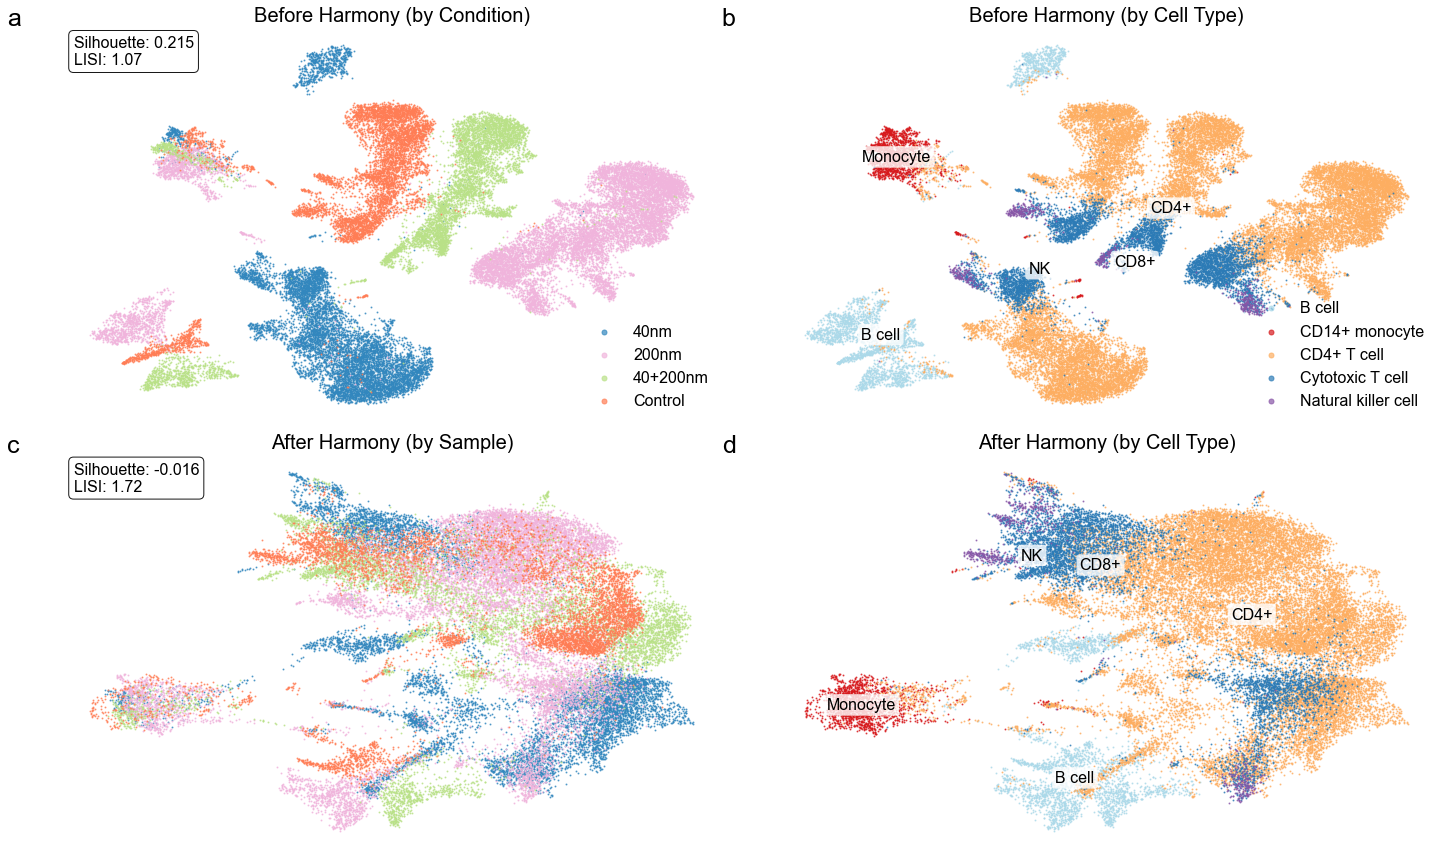

20:32:30 - INFO - Combined UMAP figure saved to fig/Supplementary_Figure_S1_UMAP_harmony.pdf


In [12]:
# ============================================================
# COMBINED 4-PANEL UMAP FIGURE with Metrics
# ============================================================

logger.info("Creating combined 4-panel UMAP figure...")

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
panel_labels = ['a', 'b', 'c', 'd']

# Panel a: Before Harmony - by Sample
plot_umap_with_labels(
    adata.obsm['X_umap_before'],
    adata.obs[sample_col].values,
    SAMPLE_COLORS,
    axes[0, 0],
    title='Before Harmony (by Condition)',
    label_names=SAMPLE_NAMES
)
# Add metrics to panel a
metrics_text_a = f"Silhouette: {metrics_before['Silhouette (batch)']:.3f}\nLISI: {metrics_before['LISI (batch)']:.2f}"
axes[0, 0].text(0.02, 0.98, metrics_text_a, transform=axes[0, 0].transAxes,
                fontsize=16, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# Panel b: Before Harmony - by Cell Type (with centroid labels)
plot_umap_with_labels(
    adata.obsm['X_umap_before'],
    adata.obs[cell_type_col].values,
    CELL_TYPE_COLORS,
    axes[0, 1],
    title='Before Harmony (by Cell Type)',
    add_centroids=True,
    short_map=CELL_TYPE_SHORT_MAP
)

# Panel c: After Harmony - by Sample
plot_umap_with_labels(
    adata.obsm['X_umap_after'],
    adata.obs[sample_col].values,
    SAMPLE_COLORS,
    axes[1, 0],
    title='After Harmony (by Sample)',
    label_names=SAMPLE_NAMES,
    legend_on=False
)
# Add metrics to panel c
metrics_text_c = f"Silhouette: {metrics_after['Silhouette (batch)']:.3f}\nLISI: {metrics_after['LISI (batch)']:.2f}"
axes[1, 0].text(0.02, 0.98, metrics_text_c, transform=axes[1, 0].transAxes,
                fontsize=16, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# Panel d: After Harmony - by Cell Type (with centroid labels)
plot_umap_with_labels(
    adata.obsm['X_umap_after'],
    adata.obs[cell_type_col].values,
    CELL_TYPE_COLORS,
    axes[1, 1],
    title='After Harmony (by Cell Type)',
    add_centroids=True,
    short_map=CELL_TYPE_SHORT_MAP,
    legend_on=False
)

# Add panel labels (a, b, c, d) - no bold
for idx, (ax, label) in enumerate(zip(axes.flatten(), panel_labels)):
    ax.text(-0.08, 1.05, label, transform=ax.transAxes, fontsize=25, verticalalignment='top')

plt.tight_layout()
plt.savefig(FIG_DIR / 'Supplementary_Figure_S1_UMAP_harmony.pdf', bbox_inches='tight', dpi=300)
plt.show()
logger.info(f"Combined UMAP figure saved to {FIG_DIR / 'Supplementary_Figure_S1_UMAP_harmony.pdf'}")

20:32:30 - INFO - Creating Supplementary Figure S2 (QC and robustness)...
20:32:35 - INFO -   Loaded data for QC analysis
20:32:36 - INFO - a) QC metrics by condition
20:32:36 - INFO - Panel S1B: QC metrics by cell type...
20:32:37 - INFO -   Panel S1C: Pseudobulk PCA
20:32:37 - INFO -   Panel S1D: Marker gene validation...
20:32:42 - INFO - maxp pruned
20:32:42 - INFO - LTSH dropped
20:32:42 - INFO - cmap pruned
20:32:42 - INFO - kern dropped
20:32:42 - INFO - post pruned
20:32:42 - INFO - PCLT dropped
20:32:42 - INFO - GPOS pruned
20:32:42 - INFO - GSUB pruned
20:32:42 - INFO - JSTF dropped
20:32:42 - INFO - DSIG dropped
20:32:42 - INFO - name pruned
20:32:42 - INFO - glyf pruned
20:32:42 - INFO - Added gid0 to subset
20:32:42 - INFO - Added first four glyphs to subset
20:32:42 - INFO - Closing glyph list over 'GSUB': 56 glyphs before
20:32:42 - INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'S', 'T', 'U', 'a', 'b', 'c', 'd',

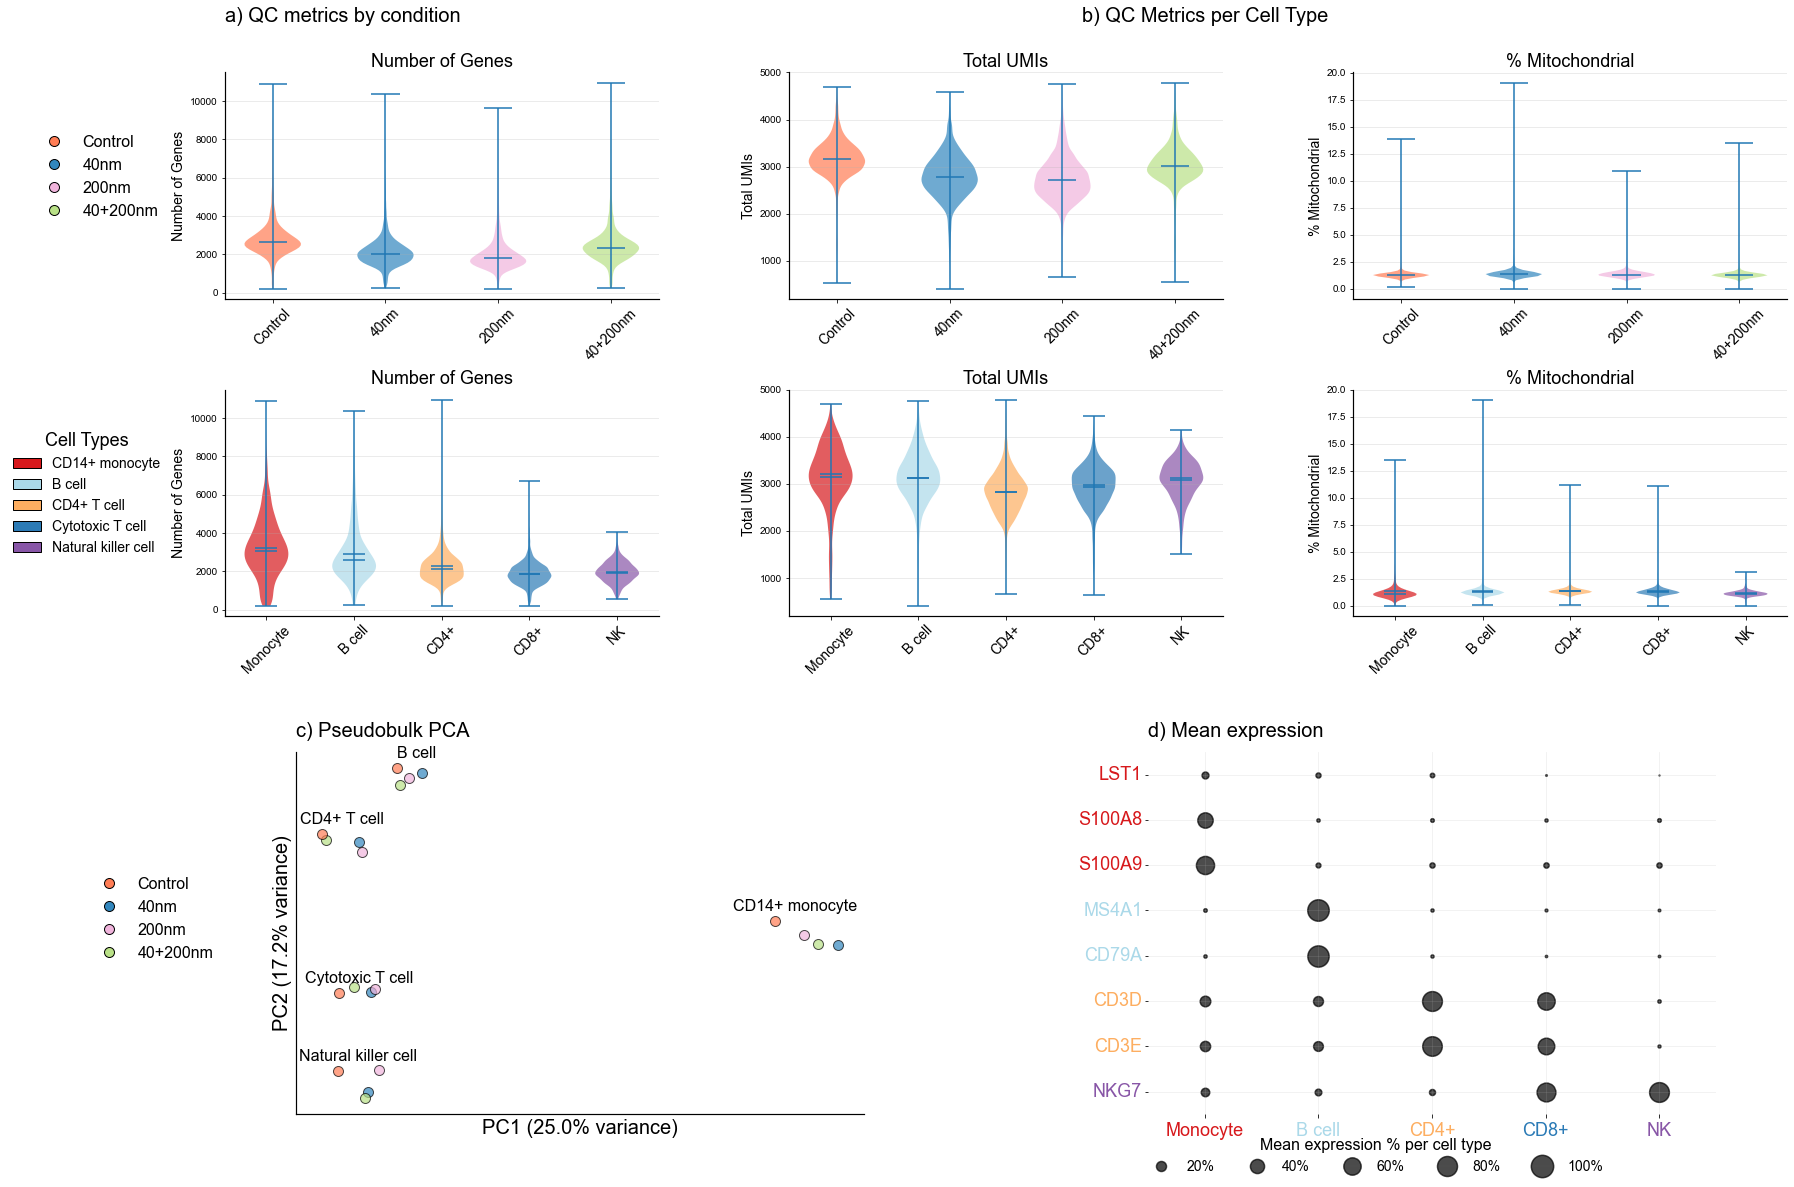

In [13]:
"""
SUPPLEMENTARY FIGURE S2: scRNA-seq quality control and robustness
- Panel S1A: Per-cell QC metrics (violin plots)
- Panel S1B: QC metrics per cell type
- Panel S1C: Pseudobulk PCA
- Panel S1D: Marker gene validation
"""
logger.info("Creating Supplementary Figure S2 (QC and robustness)...")

# Load AnnData if not already loaded
try:
    adata_qc = sc.read_h5ad('../data/merged_harmony.h5ad')
    logger.info("  Loaded data for QC analysis")
except:
    logger.error("  Could not load h5ad file for QC")
    adata_qc = None

if adata_qc is not None:
    # Detect cell type column
    ct_col = 'CoDi_dist'  # Use CoDi_dist annotation as specified
    sample_col = 'sample'
    
    # Calculate QC metrics if not present
    if 'n_genes' not in adata_qc.obs.columns:
        adata_qc.obs['n_genes'] = (adata_qc.X > 0).sum(axis=1)
    if 'n_counts' not in adata_qc.obs.columns:
        adata_qc.obs['n_counts'] = adata_qc.X.sum(axis=1)
    if 'pct_mito' not in adata_qc.obs.columns:
        mito_genes = adata_qc.var_names.str.startswith('MT-')
        if mito_genes.sum() > 0:
            adata_qc.obs['pct_mito'] = (adata_qc.X[:, mito_genes].sum(axis=1) / 
                                        adata_qc.X.sum(axis=1) * 100)
        else:
            adata_qc.obs['pct_mito'] = 0
    
    # Create figure
    figS1 = plt.figure(figsize=(28, 20))
    gsS1 = figS1.add_gridspec(3, 1, height_ratios=[1,1,2],     # ← this controls the vertical split
                              hspace=0.30, wspace=0.25)
    
    # ============================================================
    # Panel S1A: Per-cell QC metrics by condition
    # ============================================================
    logger.info("a) QC metrics by condition")
    
    gs_s1a = gsS1[0, 0].subgridspec(1, 3, wspace=0.3)
    
    qc_metrics = [
        ('n_genes', 'Number of Genes'),
        ('n_counts', 'Total UMIs'),
        ('pct_mito', '% Mitochondrial')
    ]
    
    # Map sample names
    adata_qc.obs['condition'] = adata_qc.obs[sample_col].map(SAMPLE_NAMES)
    
    for idx, (metric, title) in enumerate(qc_metrics):
        ax = figS1.add_subplot(gs_s1a[0, idx])
        
        # Create violin plot
        conditions = ['Control', '40nm', '200nm', '40+200nm']
        data_by_condition = []
        for cond in conditions:
            mask = adata_qc.obs['condition'] == cond
            if mask.sum() > 0:
                data_by_condition.append(adata_qc.obs.loc[mask, metric].values)
            else:
                data_by_condition.append([])
        
        parts = ax.violinplot(data_by_condition, positions=range(len(conditions)),
                             showmeans=False, showmedians=True)
        
        for pc, cond in zip(parts['bodies'], conditions):
            pc.set_facecolor(SAMPLE_COLORS.get(cond, '#808080'))
            pc.set_alpha(0.7)
        
        ax.set_xticks(range(len(conditions)))
        ax.set_xticklabels(conditions, rotation=45, ha='center', fontsize=14)
        ax.set_ylabel(title, fontsize=14)
        ax.set_title(f'{title}', fontsize=18)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', alpha=0.3)
        if (idx == 0):
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=SAMPLE_COLORS.get(SAMPLE_NAMES[s], '#808080'),
                                  markersize=10, label=SAMPLE_NAMES[s], markeredgecolor='black')
                       for s in ['sample_4', 'sample_1', 'sample_2', 'sample_3']]
            ax.legend(handles=legend_elements, loc='center right', fontsize=16, ncol=1, bbox_to_anchor=(-0.12, 0.54), frameon=False)
            
        
    
    figS1.text(0.125, 0.915, 'a) QC metrics by condition',
              fontsize=20)
    
    # ============================================================
    # Panel S1B: QC metrics per cell type
    # ============================================================
    logger.info("Panel S1B: QC metrics by cell type...")
    
    gs_s1b = gsS1[1, 0].subgridspec(1, 3, wspace=0.3)
    
    for idx, (metric, title) in enumerate(qc_metrics):
        ax = figS1.add_subplot(gs_s1b[0, idx])
        
        data_by_ct = []
        for ct in CELL_TYPE_ORDER:
            mask = adata_qc.obs[ct_col] == ct
            if mask.sum() > 0:
                data_by_ct.append(adata_qc.obs.loc[mask, metric].values)
            else:
                data_by_ct.append([])
        
        parts = ax.violinplot(data_by_ct, positions=range(len(CELL_TYPE_ORDER)),
                             showmeans=True, showmedians=True)
        
        for pc, ct in zip(parts['bodies'], CELL_TYPE_ORDER):
            pc.set_facecolor(CELL_TYPE_COLORS[ct])
            pc.set_alpha(0.7)
        
        ax.set_xticks(range(len(CELL_TYPE_ORDER)))
        ax.set_xticklabels([CELL_TYPE_SHORT_MAP[ct] for ct in CELL_TYPE_ORDER], rotation=45, ha='center', fontsize=14)
        ax.set_ylabel(title, fontsize=14)
        ax.set_title(f'{title}', fontsize=18)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', alpha=0.3)
        if (idx == 0):
            cell_type_legend_elements = [Patch(facecolor=CELL_TYPE_COLORS[ct], edgecolor='black',
                                       label=ct) for ct in CELL_TYPE_ORDER]
            ax.legend(handles=cell_type_legend_elements, loc='center right',
                bbox_to_anchor=(-0.12, 0.54), fontsize=14, frameon=False,
                title='Cell Types', title_fontsize=18, ncol=1)
    
    figS1.text(0.55, 0.915, 'b) QC Metrics per Cell Type',
              fontsize=20)
    
    # ============================================================
    # Panel S1C: Pseudobulk PCA
    # ============================================================
    logger.info("  Panel S1C: Pseudobulk PCA")
    
    # ax_s1c = figS1.add_subplot(gsS1[1, 0])

    gs_s1cd = gsS1[2, 0].subgridspec(1, 2)
    ax_s1c = figS1.add_subplot(gs_s1cd[0, 0])
    pos = ax_s1c.get_position()
    ax_s1c.set_position([
        pos.x0 + pos.width * 0.1,
        pos.y0 + pos.height * 0.1,
        pos.width * 0.8,
        pos.height * 0.8
    ])



    
    # Create pseudobulk profiles
    pseudobulk_data = []
    pseudobulk_labels = []
    
    for ct in CELL_TYPE_ORDER:
        for sample in ['sample_1', 'sample_2', 'sample_3', 'sample_4']:
            mask = (adata_qc.obs[ct_col] == ct) & (adata_qc.obs[sample_col] == sample)
            if mask.sum() > 5:  # Minimum cells
                mean_expr = np.array(adata_qc.X[mask.values, :].mean(axis=0)).flatten()
                pseudobulk_data.append(mean_expr)
                pseudobulk_labels.append((ct, SAMPLE_NAMES[sample]))
    
    if len(pseudobulk_data) > 0:
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        
        X = np.array(pseudobulk_data)
        X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        
        # Plot
        for i, (ct, cond) in enumerate(pseudobulk_labels):
            ax_s1c.scatter(X_pca[i, 0], X_pca[i, 1],
                          c=[SAMPLE_COLORS.get(cond, '#808080')],
                          s=100, alpha=0.7, edgecolors='black', linewidths=1)
            if cond == 'Control': # Add only one label per cell type
                ax_s1c.text(X_pca[i, 0] + 8, X_pca[i, 1] + 8, ct, fontsize=16, ha='center', va='center')
        
        # Set axis labels with variance explained
        ax_s1c.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)',
                         fontsize=20)
        ax_s1c.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)',
                         fontsize=20)
        ax_s1c.set_xticks([])
        ax_s1c.set_yticks([])
    
    ax_s1c.set_title('c) Pseudobulk PCA',
                    fontsize=20, loc='left', pad=15)
    ax_s1c.spines['top'].set_visible(False)
    ax_s1c.spines['right'].set_visible(False)
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=SAMPLE_COLORS.get(SAMPLE_NAMES[s], '#808080'),
                                  markersize=10, label=SAMPLE_NAMES[s], markeredgecolor='black')
                       for s in ['sample_4', 'sample_1', 'sample_2', 'sample_3']]
    ax_s1c.legend(handles=legend_elements, loc='center right', fontsize=16, ncol=1, bbox_to_anchor=(-0.12, 0.54), frameon=False)
    
    # ============================================================
    # Panel S1D: Marker gene validation
    # ============================================================
    logger.info("  Panel S1D: Marker gene validation...")
    
    # ax_s1d = figS1.add_subplot(gsS1[1, 1])

    # gs_s1d = gsS1[1, 1].subgridspec(
    #     3, 3,
    #     height_ratios=[1, 6, 1],
    #     width_ratios=[1, 6, 1]
    # )
    ax_s1d = figS1.add_subplot(gs_s1cd[0, 1])

    pos = ax_s1d.get_position()
    ax_s1d.set_position([
        pos.x0 + pos.width * 0.1,
        pos.y0 + pos.height * 0.1,
        pos.width * 0.8,
        pos.height * 0.8
    ])

    
    # Define canonical markers
    markers = {
        'CD14+ monocyte': ['LST1', 'S100A8', 'S100A9'],
        'B cell': ['MS4A1', 'CD79A'],
        'CD4+ T cell': ['CD3D', 'CD3E'],
        'Natural killer cell': ['NKG7']
    }
    
    # Flatten marker list
    all_markers = []
    marker_labels = []
    for ct in CELL_TYPE_ORDER:
        if ct in markers:
            for marker in markers[ct]:
                if marker in adata_qc.var_names:
                    all_markers.append(marker)
                    marker_labels.append(f"{ct}, {marker}")
    
    # Calculate mean expression per cell type
    marker_expr_matrix = []
    for marker in all_markers:
        expr_row = []
        marker_idx = adata_qc.var_names.tolist().index(marker)
        for ct in CELL_TYPE_ORDER:
            mask = adata_qc.obs[ct_col] == ct
            if mask.sum() > 0:
                mean_expr = np.array(adata_qc.X[mask.values, marker_idx].mean())
                pct_expr = (adata_qc.X[mask.values, marker_idx] > 0).sum() / mask.sum() * 100
                expr_row.append((mean_expr, pct_expr))
            else:
                expr_row.append((0, 0))
        marker_expr_matrix.append(expr_row)
    
    # Dot plot
    for i, marker_label in enumerate(marker_labels):
        for j, ct in enumerate(CELL_TYPE_ORDER):
            if i < len(marker_expr_matrix):
                mean_expr, pct_expr = marker_expr_matrix[i][j]
                size = pct_expr * 5
#                 color_intensity = min(mean_expr / 2, 1)  # Normalize
                ax_s1d.scatter(j, i, s=size, c='k',
                              alpha=0.7, edgecolors='black', linewidths=1.5)
    
    ax_s1d.set_yticks(range(len(marker_labels)))
    for i, label in enumerate(marker_labels):
        parts = label.split(', ')
        color = CELL_TYPE_COLORS.get(parts[0], '#000000')
        ax_s1d.text(-0.55, i, parts[1], va='center', ha='right', fontsize=18,
                   color=color)
    ax_s1d.set_yticklabels([])
    
    ax_s1d.set_xticks(range(len(CELL_TYPE_ORDER)))
    ax_s1d.set_xticklabels([ct for ct in CELL_TYPE_ORDER], rotation=0, ha='center', fontsize=18)
    # Then apply colors using your dictionary
    for label in ax_s1d.get_xticklabels():
        text = label.get_text()
        if text in CELL_TYPE_COLORS:
            label.set_color(CELL_TYPE_COLORS[text])
    ax_s1d.set_xticklabels([CELL_TYPE_SHORT_MAP[ct] for ct in CELL_TYPE_ORDER], rotation=0, ha='center', fontsize=18)

    ax_s1d.set_title('d) Mean expression',
                    fontsize=20, loc='left', pad=15)
    ax_s1d.set_xlim(-0.5, len(CELL_TYPE_ORDER) - 0.5)
    ax_s1d.set_ylim(-0.5, len(marker_labels) - 0.5)
    ax_s1d.grid(True, alpha=0.2)
    ax_s1d.invert_yaxis()
    ax_s1d.spines['top'].set_visible(False)
    ax_s1d.spines['right'].set_visible(False)
    ax_s1d.spines['bottom'].set_visible(False)
    ax_s1d.spines['left'].set_visible(False)

    # Add cell type legend at top left of the figure S1d
    

    # Add size legend for dot plot (top right corner of panel S1D)
    size_legend_pcts = [20, 40, 60, 80, 100]  # Percentage values to show
    size_legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                        markerfacecolor='k', alpha=0.7,
                                        markersize=np.sqrt(pct * 5),  # Match the size scaling
                                        markeredgecolor='black', markeredgewidth=1.5,
                                        label=f'{pct}%')
                            for pct in size_legend_pcts]
    ax_s1d.legend(handles=size_legend_elements, loc='lower center',
                bbox_to_anchor=(0.4, -0.2), fontsize=14, frameon=False,
                title='Mean expression % per cell type', title_fontsize=16, ncol=5,
                labelspacing=0.5)

    plt.savefig(FIG_DIR / 'Supplementary_Figure_S2_QC.pdf', bbox_inches='tight', dpi=300)
    logger.info("✓ Supplementary Figure S1 complete\n")
else:
    logger.warning("Skipping Supplementary Figure S2 (no data)\n")

# Supplementary figure S3 - All vulcano plots - missing....

20:32:43 - INFO - Creating Supplementary Figure S4 (Full KEGG analysis)...
20:32:43 - WARNING -   Sheet not found: Monocyte_40 nm
20:32:43 - WARNING -   Sheet not found: Monocyte_200 nm
20:32:43 - WARNING -   Sheet not found: Monocyte_MIX (40 + 200 nm)
20:32:43 - WARNING -   No pathway data for CD14+ monocyte
20:32:43 - WARNING -   Sheet not found: B_cell_40 nm
20:32:43 - WARNING -   Sheet not found: B_cell_200 nm
20:32:43 - WARNING -   Sheet not found: B_cell_MIX (40 + 200 nm)
20:32:43 - WARNING -   No pathway data for B cell
20:32:43 - WARNING -   Sheet not found: CD4+_T_cell_40 nm
20:32:43 - WARNING -   Sheet not found: CD4+_T_cell_200 nm
20:32:43 - WARNING -   Sheet not found: CD4+_T_cell_MIX (40 + 200 nm)
20:32:43 - WARNING -   No pathway data for CD4+ T cell
20:32:43 - WARNING -   Sheet not found: CD8+_T_cell_40 nm
20:32:43 - WARNING -   Sheet not found: CD8+_T_cell_200 nm
20:32:43 - WARNING -   Sheet not found: CD8+_T_cell_MIX (40 + 200 nm)
20:32:43 - WARNING -   No pathway data

Processing CD14+ monocyte - 40nm
Processing CD14+ monocyte - 200nm
Processing CD14+ monocyte - 40+200nm
Processing B cell - 40nm
Processing B cell - 200nm
Processing B cell - 40+200nm
Processing CD4+ T cell - 40nm
Processing CD4+ T cell - 200nm
Processing CD4+ T cell - 40+200nm
Processing Cytotoxic T cell - 40nm
Processing Cytotoxic T cell - 200nm
Processing Cytotoxic T cell - 40+200nm
Processing Natural killer cell - 40nm
Processing Natural killer cell - 200nm
Processing Natural killer cell - 40+200nm


20:32:44 - INFO - GPOS subsetted
20:32:44 - INFO - GSUB subsetted
20:32:44 - INFO - name subsetting not needed
20:32:44 - INFO - glyf subsetted
20:32:44 - INFO - head pruned
20:32:44 - INFO - OS/2 Unicode ranges pruned: [0]
20:32:44 - INFO - glyf pruned
20:32:44 - INFO - GDEF pruned
20:32:44 - INFO - GPOS pruned
20:32:44 - INFO - GSUB pruned
20:32:44 - INFO - ✓ Supplementary Figure S4 complete



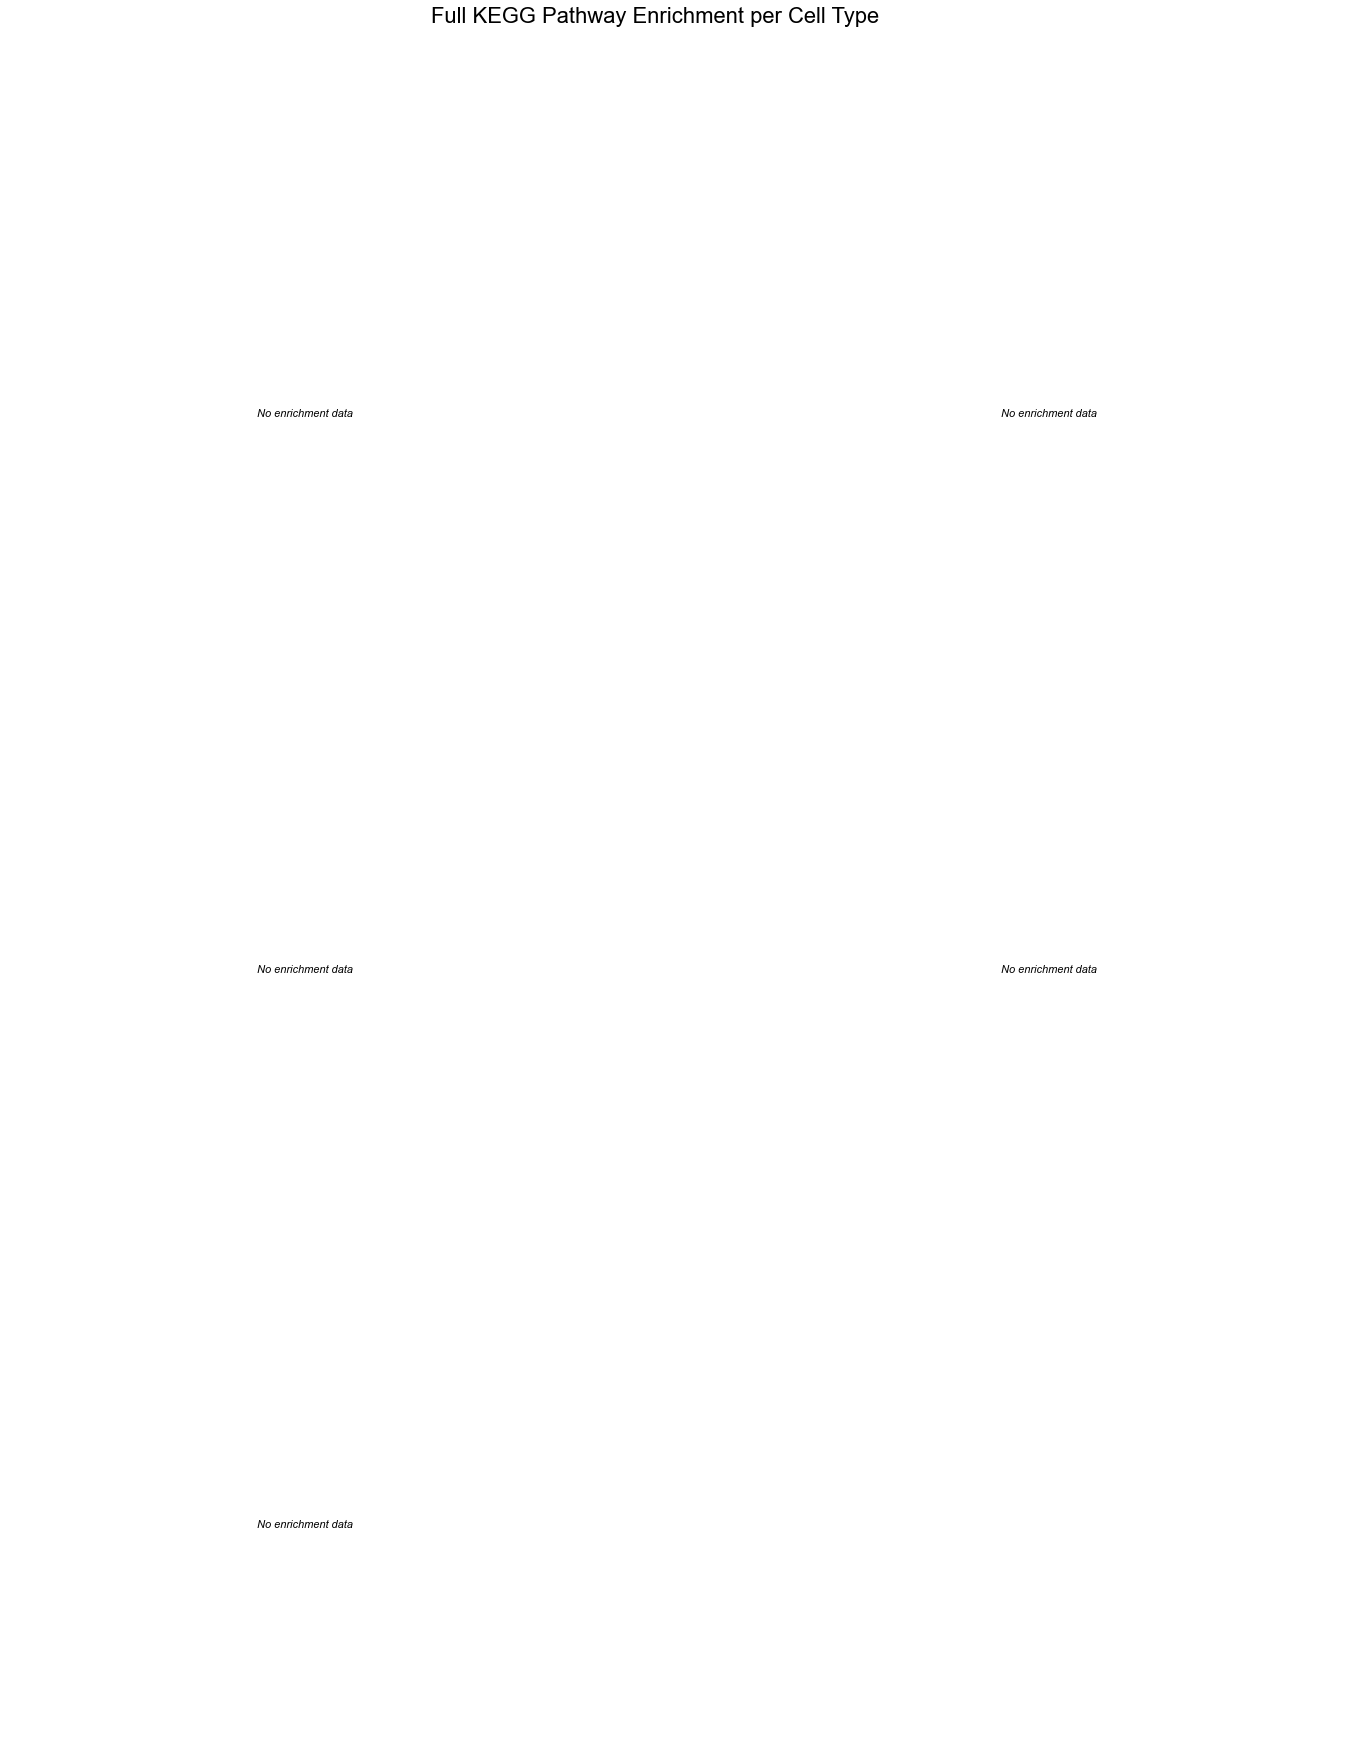

In [14]:
logger.info("Creating Supplementary Figure S4 (Full KEGG analysis)...")

# Create figure S3 with panels for each cell type
figS4 = plt.figure(figsize=(24, 28))
gsS4 = figS4.add_gridspec(3, 2, hspace=0.35, wspace=0.25)

for idx, cell_type in enumerate(CELL_TYPE_ORDER):
    row = idx // 2
    col = idx % 2
    ax = figS4.add_subplot(gsS4[row, col])

    # Collect all pathways for this cell type across conditions
    pathway_data = {}

    for condition in samples:
        print(f"Processing {cell_type} - {condition}")
        sheet_name = get_gse_sheet_name(CELL_TYPE_SHORT_MAP_ALT[cell_type], condition)
        if sheet_name and sheet_name in gse_results:
            df = gse_results[sheet_name]
            logger.info(f"  Processing {sheet_name}")

            # Determine column name
            term_col = 'KEGG Term' if 'KEGG Term' in df.columns else 'Term'

            # Get top 20 pathways by NES
            # Skip if empty or convert NES to numeric
            if len(df) == 0:
                logger.warning(f"  Sheet {sheet_name} is empty, skipping")
                continue
            df["NES"] = pd.to_numeric(df["NES"], errors="coerce")

            top_pathways = df.nlargest(20, 'NES')
            for _, row_data in top_pathways.iterrows():
                pathway = row_data[term_col][:50]  # Truncate long names
                if pathway not in pathway_data:
                    pathway_data[pathway] = {}
                pathway_data[pathway][condition] = row_data['NES']
        else:
            logger.warning(f"  Sheet not found: {sheet_name}")
    # print(pathway_data)
    if len(pathway_data) > 0:
        # Create dot plot
        pathways = list(pathway_data.keys())[:20]  # Top 20
        y_positions = np.arange(len(pathways))

        logger.info(f"  Plotting {len(pathways)} pathways for {cell_type}")

        # Check if we have any data to plot
        has_data = False
        for pathway in pathways:
            if any(pathway_data[pathway].get(c, 0) != 0 for c in samples):
                has_data = True
                break

        if not has_data:
            ax.text(0.5, 0.5, 'No enrichment data', ha='center', va='center',
                   fontsize=11, style='italic', transform=ax.transAxes)
            ax.axis('off')
            logger.warning(f'  No data to plot for {cell_type}')
        else:
            # Plot points and track if any were actually plotted
            points_plotted = False
            x_spacing = 0.5
            x_positions = np.arange(len(samples)) * x_spacing  # spacing factor
            for i, pathway in enumerate(pathways):
                for j, condition in enumerate(samples):
                    nes = pathway_data[pathway].get(condition, 0)
                    if nes != 0 and not pd.isna(nes):
                        size = abs(nes) * 150
                        color = SAMPLE_COLORS[condition]
                        ax.scatter(x_positions[j], i, s=size, c=[color], alpha=0.7,
                                 edgecolors='black', linewidths=0.5)
                        points_plotted = True

            if not points_plotted:
                ax.text(0.5, 0.5, 'No enrichment data', ha='center', va='center',
                       fontsize=11, style='italic', transform=ax.transAxes)
                ax.axis('off')
                logger.warning(f'  No valid NES values to plot for {cell_type}')
            else:
                ax.set_yticks(y_positions)
                ax.set_yticklabels(pathways, fontsize=16)
                ax.set_xticks(x_positions)
                ax.set_xticklabels(samples, fontsize=20)
                ax.set_title(f'{CELL_TYPE_SHORT_MAP[cell_type]}', fontsize=22)
                ax.set_xlim(x_positions[0] - 0.5 * x_spacing,
                            x_positions[-1] + 0.5 * x_spacing)
                ax.set_ylim(-0.5, len(pathways) - 0.5)
                ax.invert_yaxis()
                ax.grid(True, alpha=0.2, axis='y')
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.tick_params(axis='x', length=0)  # remove tick marks
                ax.tick_params(axis='y', length=0)  # remove tick marks
                box = ax.get_position()
                ax.set_position([
                    box.x0 + box.width * 0.15,  # shift right (center it)
                    box.y0,                     # keep y unchanged
                    box.width * 0.7,            # 🔥 shrink X only
                    box.height                  # keep height unchanged
                ])

    else:
        ax.text(0.5, 0.5, 'No enrichment data', ha='center', va='center',
               fontsize=11, style='italic', transform=ax.transAxes)
        ax.axis('off')
        logger.warning(f"  No pathway data for {cell_type}")

figS4.suptitle('Full KEGG Pathway Enrichment per Cell Type', fontsize=22)

plt.savefig(FIG_DIR / 'Supplementary_Figure_S4_full_KEGG.pdf', bbox_inches='tight')
logger.info("✓ Supplementary Figure S4 complete\n")


22:39:20 - INFO - Creating Supplementary Figure S5...
22:39:31 - INFO - ✓ Supplementary Figure S5 PDF saved



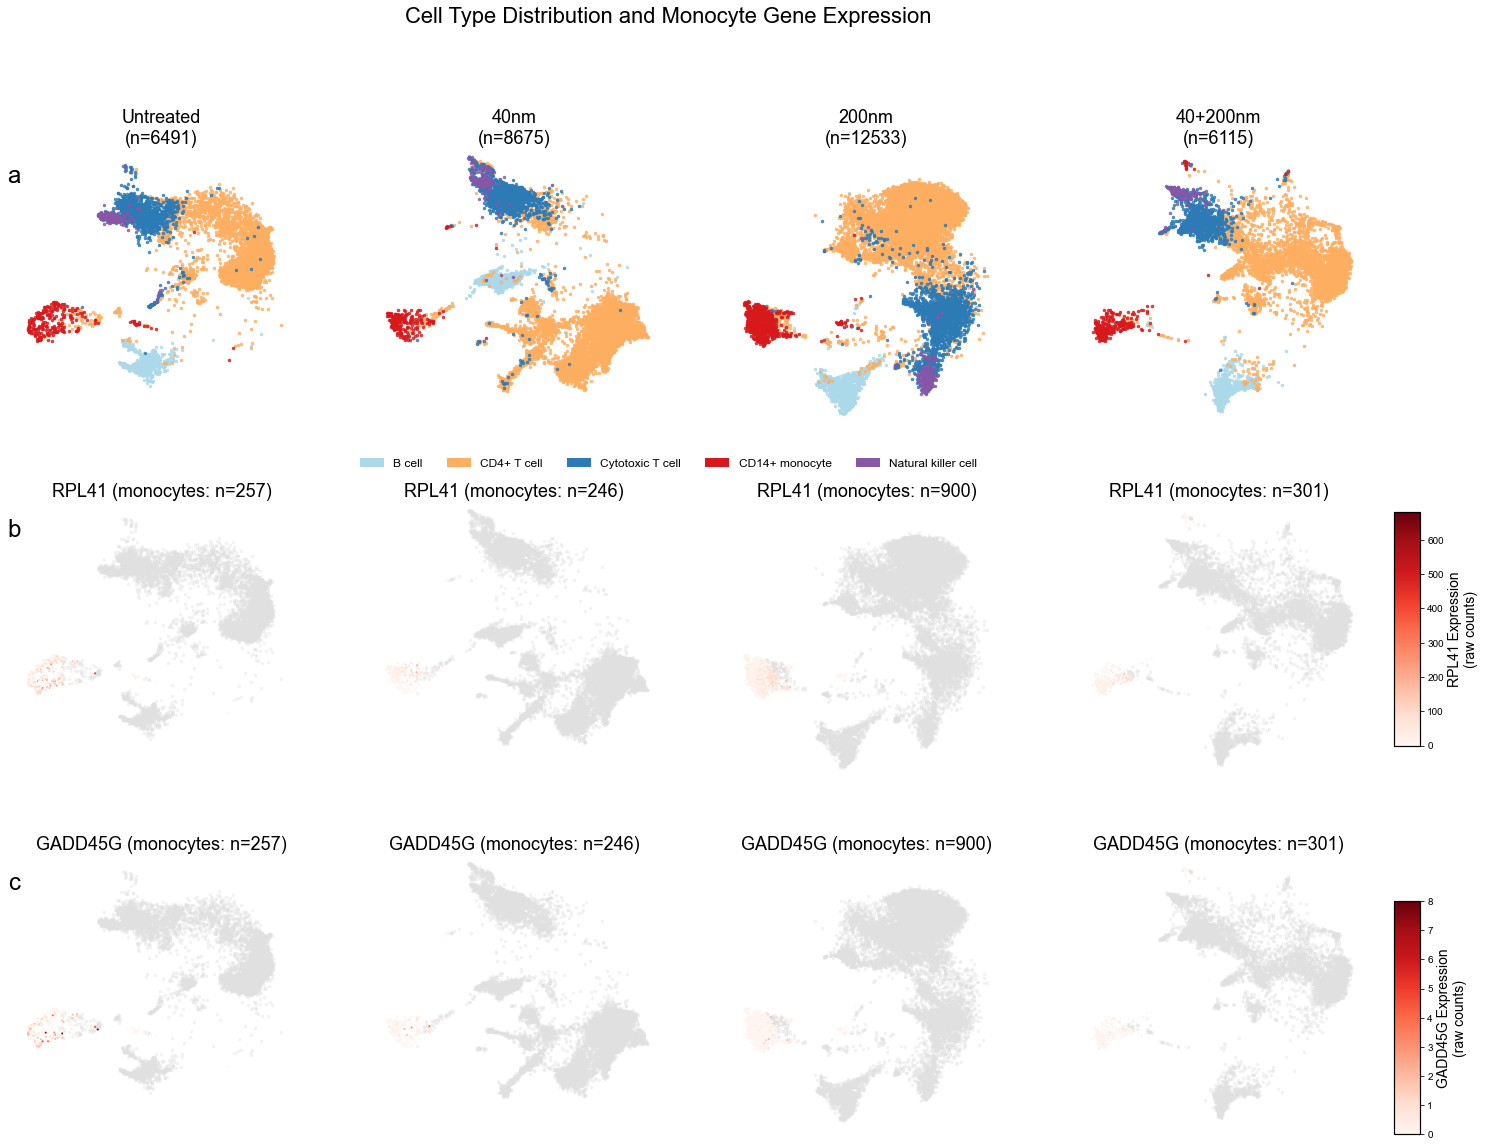

In [8]:
# ============================================================================
# SUPPLEMENTARY FIGURE S5: UMAP for RPL41 and GADD45G (Monocytes Only)
# ============================================================================
logger.info("Creating Supplementary Figure S5...")
adata = sc.read_h5ad('../data/merged_harmony.h5ad')

CELL_TYPE_ORDER = list(CELL_TYPE_COLORS.keys())
genes_to_plot = ['RPL41', 'GADD45G']
target_celltype = 'CD14+ monocyte'

if all(g in adata.var_names for g in genes_to_plot):

    fig_s4 = plt.figure(figsize=(24, 18))
    gs_s4 = fig_s4.add_gridspec(3, 4, hspace=0.3, wspace=0.25)

    conditions = [
        ('sample_4', 'Untreated'),
        ('sample_1', '40nm'),
        ('sample_2', '200nm'),
        ('sample_3', '40+200nm')
    ]

    # ----------------------------------------------------------------------
    # Global UMAP limits
    # ----------------------------------------------------------------------
    umap_all = adata.obsm['X_umap_after']
    xlim = (umap_all[:, 0].min() - 0.5, umap_all[:, 0].max() + 0.5)
    ylim = (umap_all[:, 1].min() - 0.5, umap_all[:, 1].max() + 0.5)

    # ----------------------------------------------------------------------
    # Precompute gene indices and global vmax (monocytes only)
    # ----------------------------------------------------------------------
    gene_indices = {g: adata.var_names.get_loc(g) for g in genes_to_plot}
    mono_mask_all = (adata.obs[cell_type_col] == target_celltype).values
    global_vmax = {}

    for gene, gene_idx in gene_indices.items():
        if hasattr(adata.layers['counts'], 'toarray'):
            expr = adata.layers['counts'][:, gene_idx].toarray().flatten()
        else:
            expr = np.array(adata.layers['counts'][:, gene_idx]).flatten()

        global_vmax[gene] = expr[mono_mask_all].max()

    # ============================================================
    # Row 1 (a): UMAP colored by cell type
    # ============================================================
    for idx, (sample_id, cond_name) in enumerate(conditions):

        ax = fig_s4.add_subplot(gs_s4[0, idx])

        cond_mask = adata.obs[sample_col] == sample_id
        adata_cond = adata[cond_mask]

        umap_coords = adata_cond.obsm['X_umap']
        cell_types = adata_cond.obs[cell_type_col]

        for ct in CELL_TYPE_ORDER:
            ct_mask = (cell_types == ct).values
            if ct_mask.sum() > 0:
                ax.scatter(
                    umap_coords[ct_mask, 0],
                    umap_coords[ct_mask, 1],
                    color=CELL_TYPE_COLORS[ct],
                    s=6,
                    alpha=0.8,
                    rasterized=True
                )

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_title(f'{cond_name}\n(n={cond_mask.sum()})', fontsize=18)

        if idx == 0:
            ax.text(0, 0.9, 'a', transform=ax.transAxes,
                    fontsize=24, va='center', ha='right')

        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

    # ---- Legend ----
    ct_patches = [
        Patch(facecolor=CELL_TYPE_COLORS[ct],
              edgecolor=None,
              linewidth=0.5,
              label=ct)
        for ct in CELL_TYPE_ORDER
    ]

    fig_s4.legend(
        handles=ct_patches,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.65),
        ncol=5,
        fontsize=12,
        frameon=False
    )

    # ============================================================
    # Rows 2 & 3 (b, c): Gene expression in monocytes (looped)
    # ============================================================
    scatters = {}

    for row_idx, gene in enumerate(genes_to_plot, start=1):

        for col_idx, (sample_id, cond_name) in enumerate(conditions):

            ax = fig_s4.add_subplot(gs_s4[row_idx, col_idx])

            cond_mask = adata.obs[sample_col] == sample_id
            adata_cond = adata[cond_mask]

            umap_coords = adata_cond.obsm['X_umap_after']
            cell_types = adata_cond.obs[cell_type_col]

            mono_mask = (cell_types == target_celltype).values
            non_mono_mask = ~mono_mask

            # Background cells (gray)
            if non_mono_mask.sum() > 0:
                ax.scatter(
                    umap_coords[non_mono_mask, 0],
                    umap_coords[non_mono_mask, 1],
                    c='#E0E0E0',
                    s=6,
                    alpha=0.3,
                    rasterized=True
                )

            gene_idx = gene_indices[gene]

            if hasattr(adata_cond.layers['counts'], 'toarray'):
                expression = adata_cond.layers['counts'][:, gene_idx].toarray().flatten()
            else:
                expression = np.array(adata_cond.layers['counts'][:, gene_idx]).flatten()

            if mono_mask.sum() > 0:
                scatter = ax.scatter(
                    umap_coords[mono_mask, 0],
                    umap_coords[mono_mask, 1],
                    c=expression[mono_mask],
                    s=1,
                    cmap='Reds',
                    vmin=0,
                    vmax=global_vmax[gene],
                    rasterized=True
                )
                scatters[gene] = scatter

            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_title(f'{gene} (monocytes: n={mono_mask.sum()})',
                         fontsize=18)

            if col_idx == 0:
                panel_letter = chr(ord('a') + row_idx)
                ax.text(0, 0.9, panel_letter,
                        transform=ax.transAxes,
                        fontsize=24,
                        va='center',
                        ha='right')

            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)

    # ----------------------------------------------------------------------
    # Colorbars (one per gene)
    # ----------------------------------------------------------------------
    colorbar_positions = {
        'RPL41': [0.92, 0.42, 0.015, 0.18],
        'GADD45G': [0.92, 0.12, 0.015, 0.18]
    }

    for gene in genes_to_plot:
        if gene in scatters:
            cbar_ax = fig_s4.add_axes(colorbar_positions[gene])
            cbar = fig_s4.colorbar(scatters[gene], cax=cbar_ax)
            cbar.set_label(f'{gene} Expression\n(raw counts)', fontsize=14)

    fig_s4.suptitle(
        'Cell Type Distribution and Monocyte Gene Expression',
        fontsize=22,
        y=0.99
    )

    plt.savefig(FIG_DIR / 'Supplementary_Figure_S5.pdf',
                bbox_inches='tight')
    logger.info("✓ Supplementary Figure S5 PDF saved\n")
    plt.show()

else:
    missing = [g for g in genes_to_plot if g not in adata.var_names]
    logger.warning(f"Missing genes: {missing}. Skipping Figure S5.")


In [ ]:
# ============================================================
# SUPPLEMENTARY FIGURE S6: Pseudotime Analysis
# ============================================================

# Parameter to control which UMAP coordinates to use
# Options: 'X_umap_before' (before Harmony) or 'X_umap_after' (after Harmony)
UMAP_KEY = 'X_umap_before'

# Sample labels mapping (for display)
SAMPLE_LABELS = {
    'sample_1': '40 nm',
    'sample_2': '200 nm', 
    'sample_3': '40 + 200 nm',
    'sample_4': 'Untreated'
}

# Split adata by sample for individual analysis
sample_order = ['sample_1', 'sample_2', 'sample_3', 'sample_4']
adata_by_sample = {}

for sample in sample_order:
    # Subset adata for this sample
    adata_subset = adata[adata.obs['sample'] == sample].copy()
    
    # Filter to keep only the 5 main cell types
    adata_subset = adata_subset[adata_subset.obs['CoDi_dist'].isin(CELL_TYPE_ORDER)].copy()
    
    # Ensure CoDi_dist is categorical and remove unused categories
    adata_subset.obs['CoDi_dist'] = (
        adata_subset.obs['CoDi_dist']
        .astype('category')
        .cat.remove_unused_categories()
    )
    
    # Store the UMAP coordinates in the standard location for scanpy plotting
    adata_subset.obsm['X_umap'] = adata_subset.obsm[UMAP_KEY].copy()
    
    adata_by_sample[sample] = adata_subset
    logger.info(f"Sample {sample}: {adata_subset.n_obs} cells")

logger.info(f"Using UMAP coordinates: {UMAP_KEY}")

# ============================================================
# Compute Pseudotime and PAGA for each sample
# ============================================================

sc.settings.verbosity = 0

for sample in sample_order:
    adata_s = adata_by_sample[sample]
    logger.info(f"Computing pseudotime for {SAMPLE_LABELS[sample]}...")
    
    # Compute neighbors
    sc.pp.neighbors(adata_s, n_neighbors=15, n_pcs=30)
    
    # Compute PAGA
    sc.tl.paga(adata_s, groups='CoDi_dist')
    
    # Set root cell (cell with minimum UMAP y-coordinate)
    root_cell = adata_s.obs_names[adata_s.obsm['X_umap'][:, 1].argmin()]
    adata_s.uns['iroot'] = adata_s.obs_names.get_loc(root_cell)
    
    # Compute diffusion pseudotime
    sc.tl.dpt(adata_s, n_dcs=10)
    
    logger.info(f"  ✓ {SAMPLE_LABELS[sample]} complete")

logger.info("Pseudotime computation complete for all samples")

19:41:51 - INFO - Sample sample_1: 8675 cells
19:41:52 - INFO - Sample sample_2: 12533 cells
19:41:53 - INFO - Sample sample_3: 6115 cells
19:41:54 - INFO - Sample sample_4: 6491 cells
19:41:54 - INFO - Using UMAP coordinates: X_umap_before
19:41:54 - INFO - Computing pseudotime for 40 nm...
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:21 - WARNING - findfont: Font family 'Liberation Sans' not

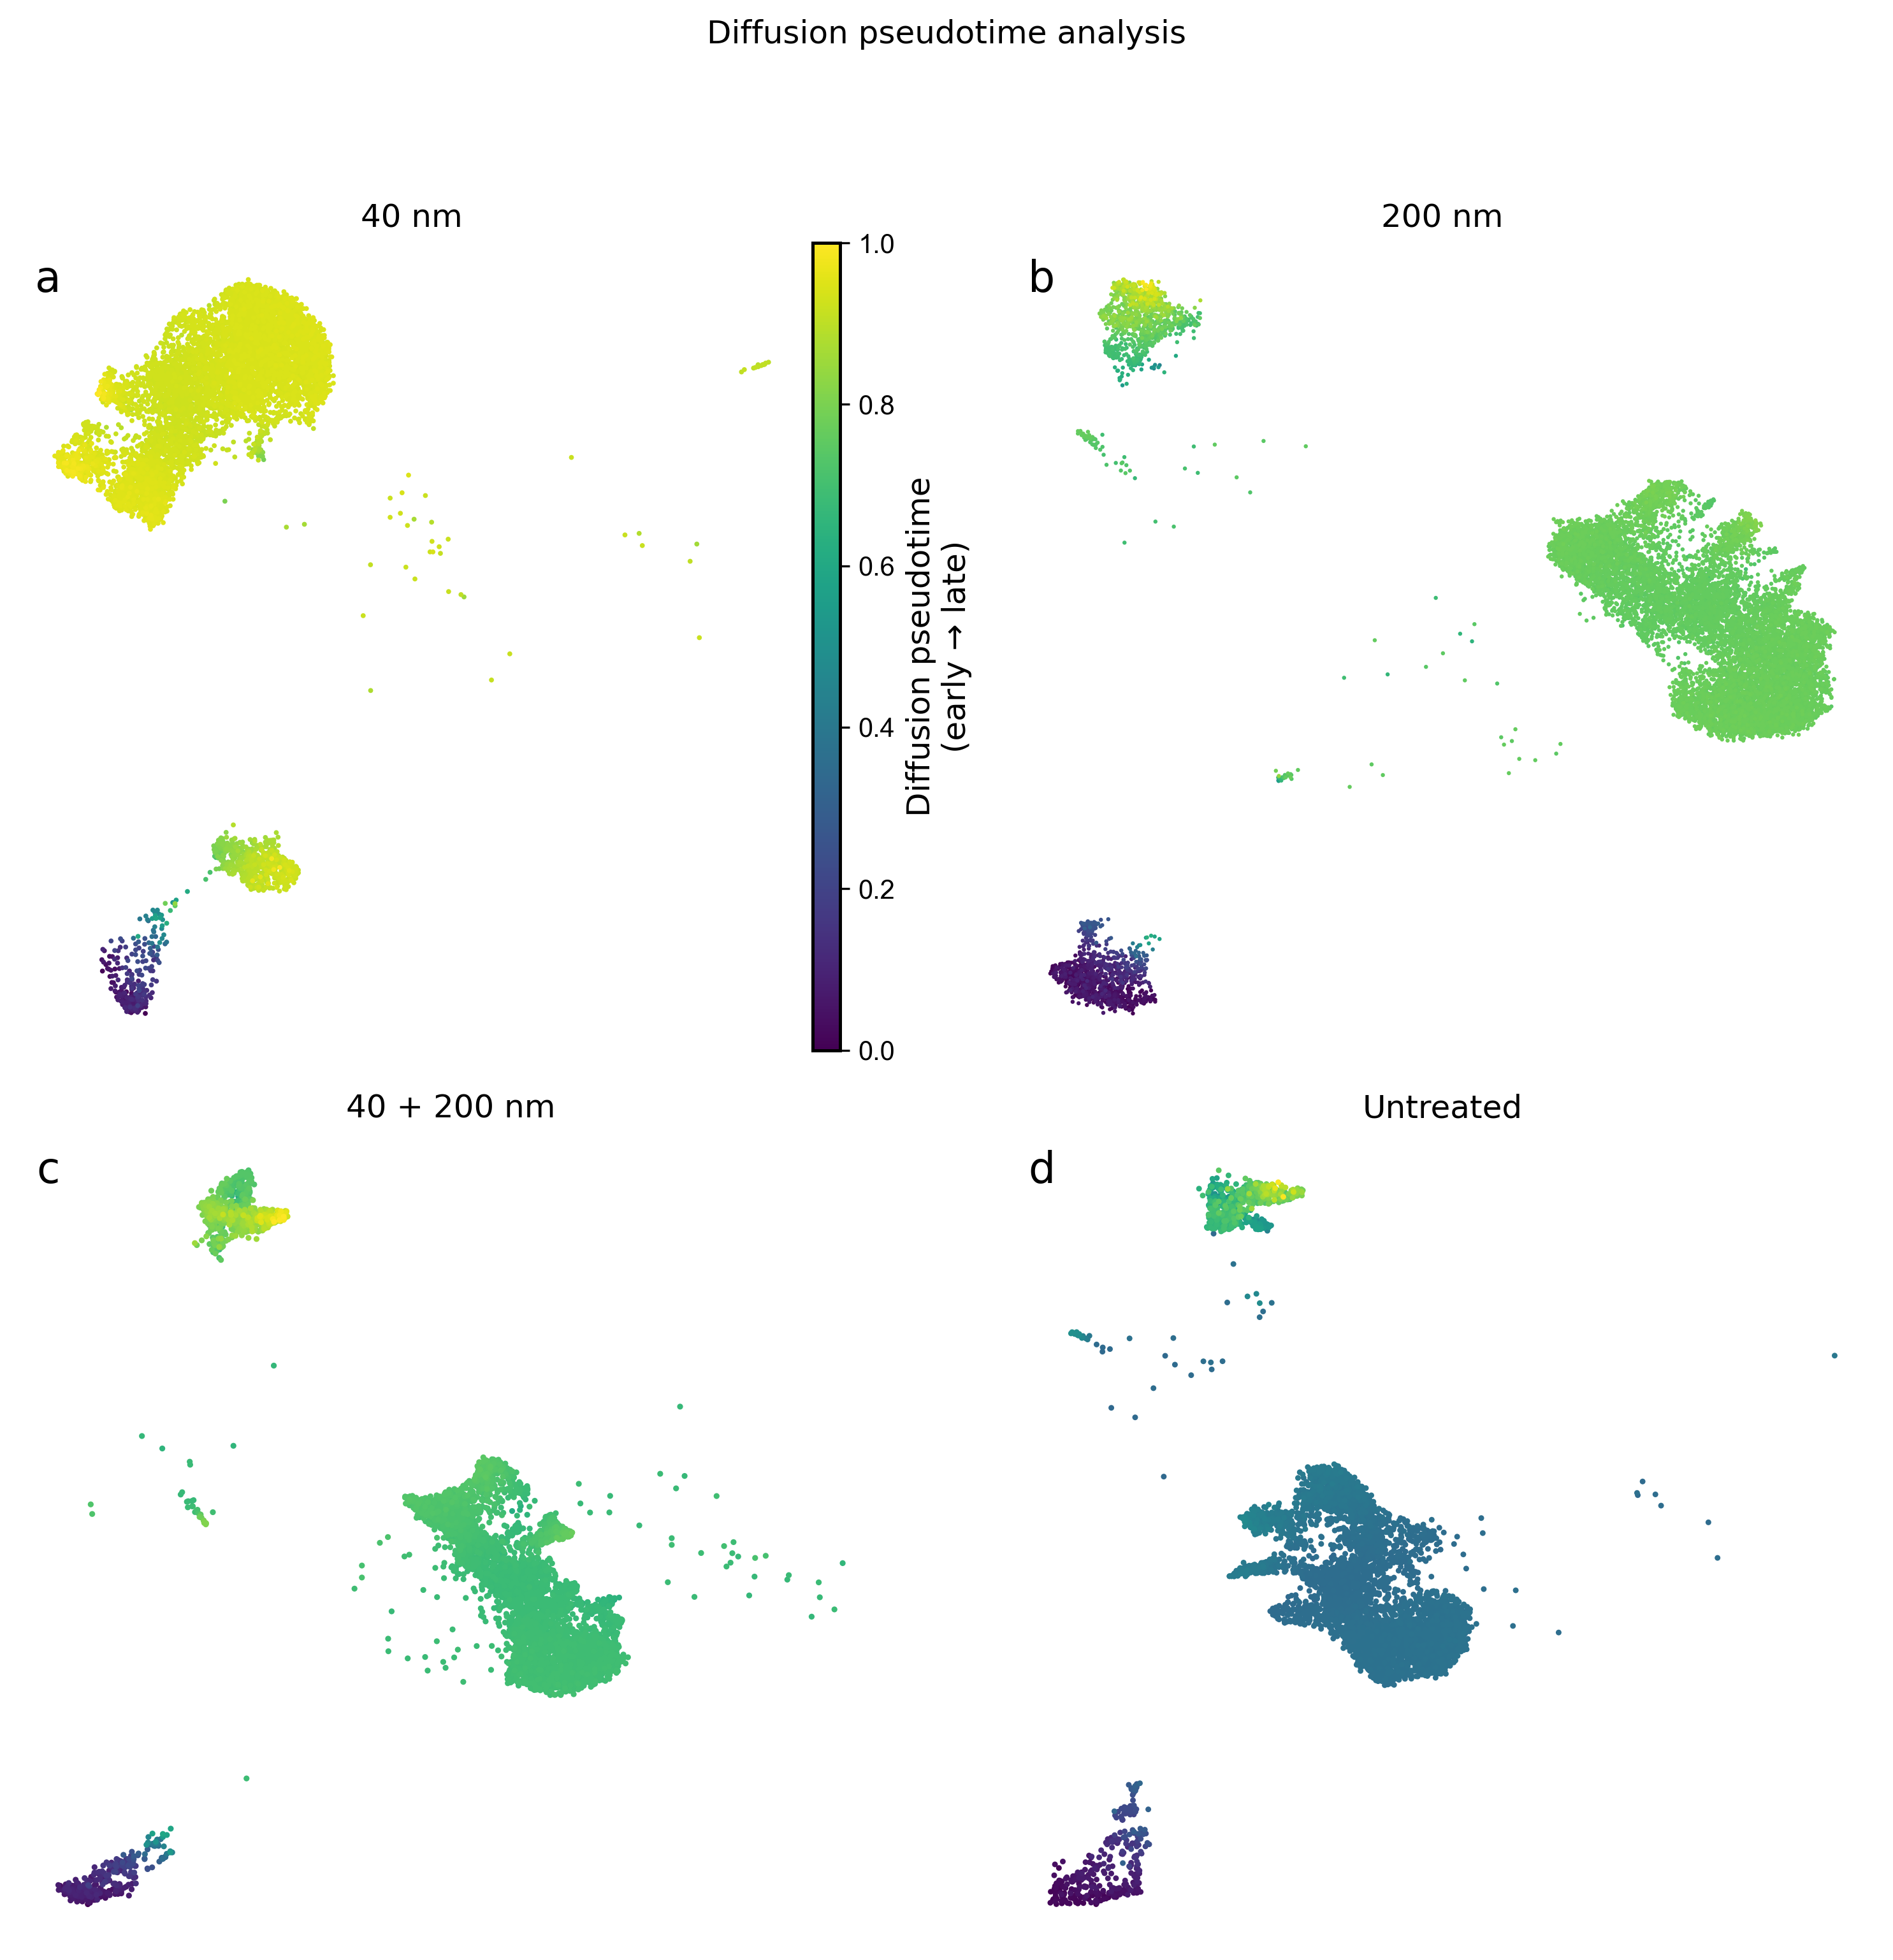

In [35]:
# ============================================================
# SUPPLEMENTARY FIGURE S6: Diffusion Pseudotime UMAP
# ============================================================

fig_s6, axes_s6 = plt.subplots(2, 2, figsize=(10, 10))
axes_s6 = axes_s6.flatten()
panel_labels = ['a', 'b', 'c', 'd']

for idx, sample in enumerate(sample_order):
    ax = axes_s6[idx]
    adata_s = adata_by_sample[sample]
    
    # Plot UMAP colored by pseudotime
    sc.pl.umap(
        adata_s,
        color='dpt_pseudotime',
        ax=ax,
        title=SAMPLE_LABELS[sample],
        show=False,
        colorbar_loc='right' if idx == 0 else None,
        cmap='viridis'
    )
    
    # Style the title (no bold)
    ax.set_title(SAMPLE_LABELS[sample], fontsize=12, fontweight='normal', fontfamily='Liberation Sans')
    
    # Remove axis labels and ticks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Add panel label
    ax.text(
        0.02, 0.98, panel_labels[idx],
        transform=ax.transAxes,
        fontsize=16,
        fontweight='normal',
        fontfamily='Liberation Sans',
        va='top',
        ha='left'
    )
    if idx == 0:
        cbar = ax.collections[0].colorbar
        cbar.set_label(
            'Diffusion pseudotime\n(early → late)',
            fontsize=12,
            fontfamily='Liberation Sans'
        )

# Main title (no bold)
fig_s6.suptitle(
    'Diffusion pseudotime analysis',
    y=1.02,
    fontsize=12,
    fontweight='normal',
    fontfamily='Liberation Sans'
)

fig_s6.tight_layout(rect=[0, 0, 1, 0.97])

# Save figure
fig_s6.savefig(FIG_DIR / 'Supplementary_Figure_S6_Pseudotime.pdf', bbox_inches='tight', dpi=300)
logger.info(f"✓ Saved Supplementary Figure S6 to {FIG_DIR / 'sup_fig_s6_pseudotime.pdf'}")
plt.show()

14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not found.
14:45:22 - WARNING - findfont: Font family 'Liberation Sans' not

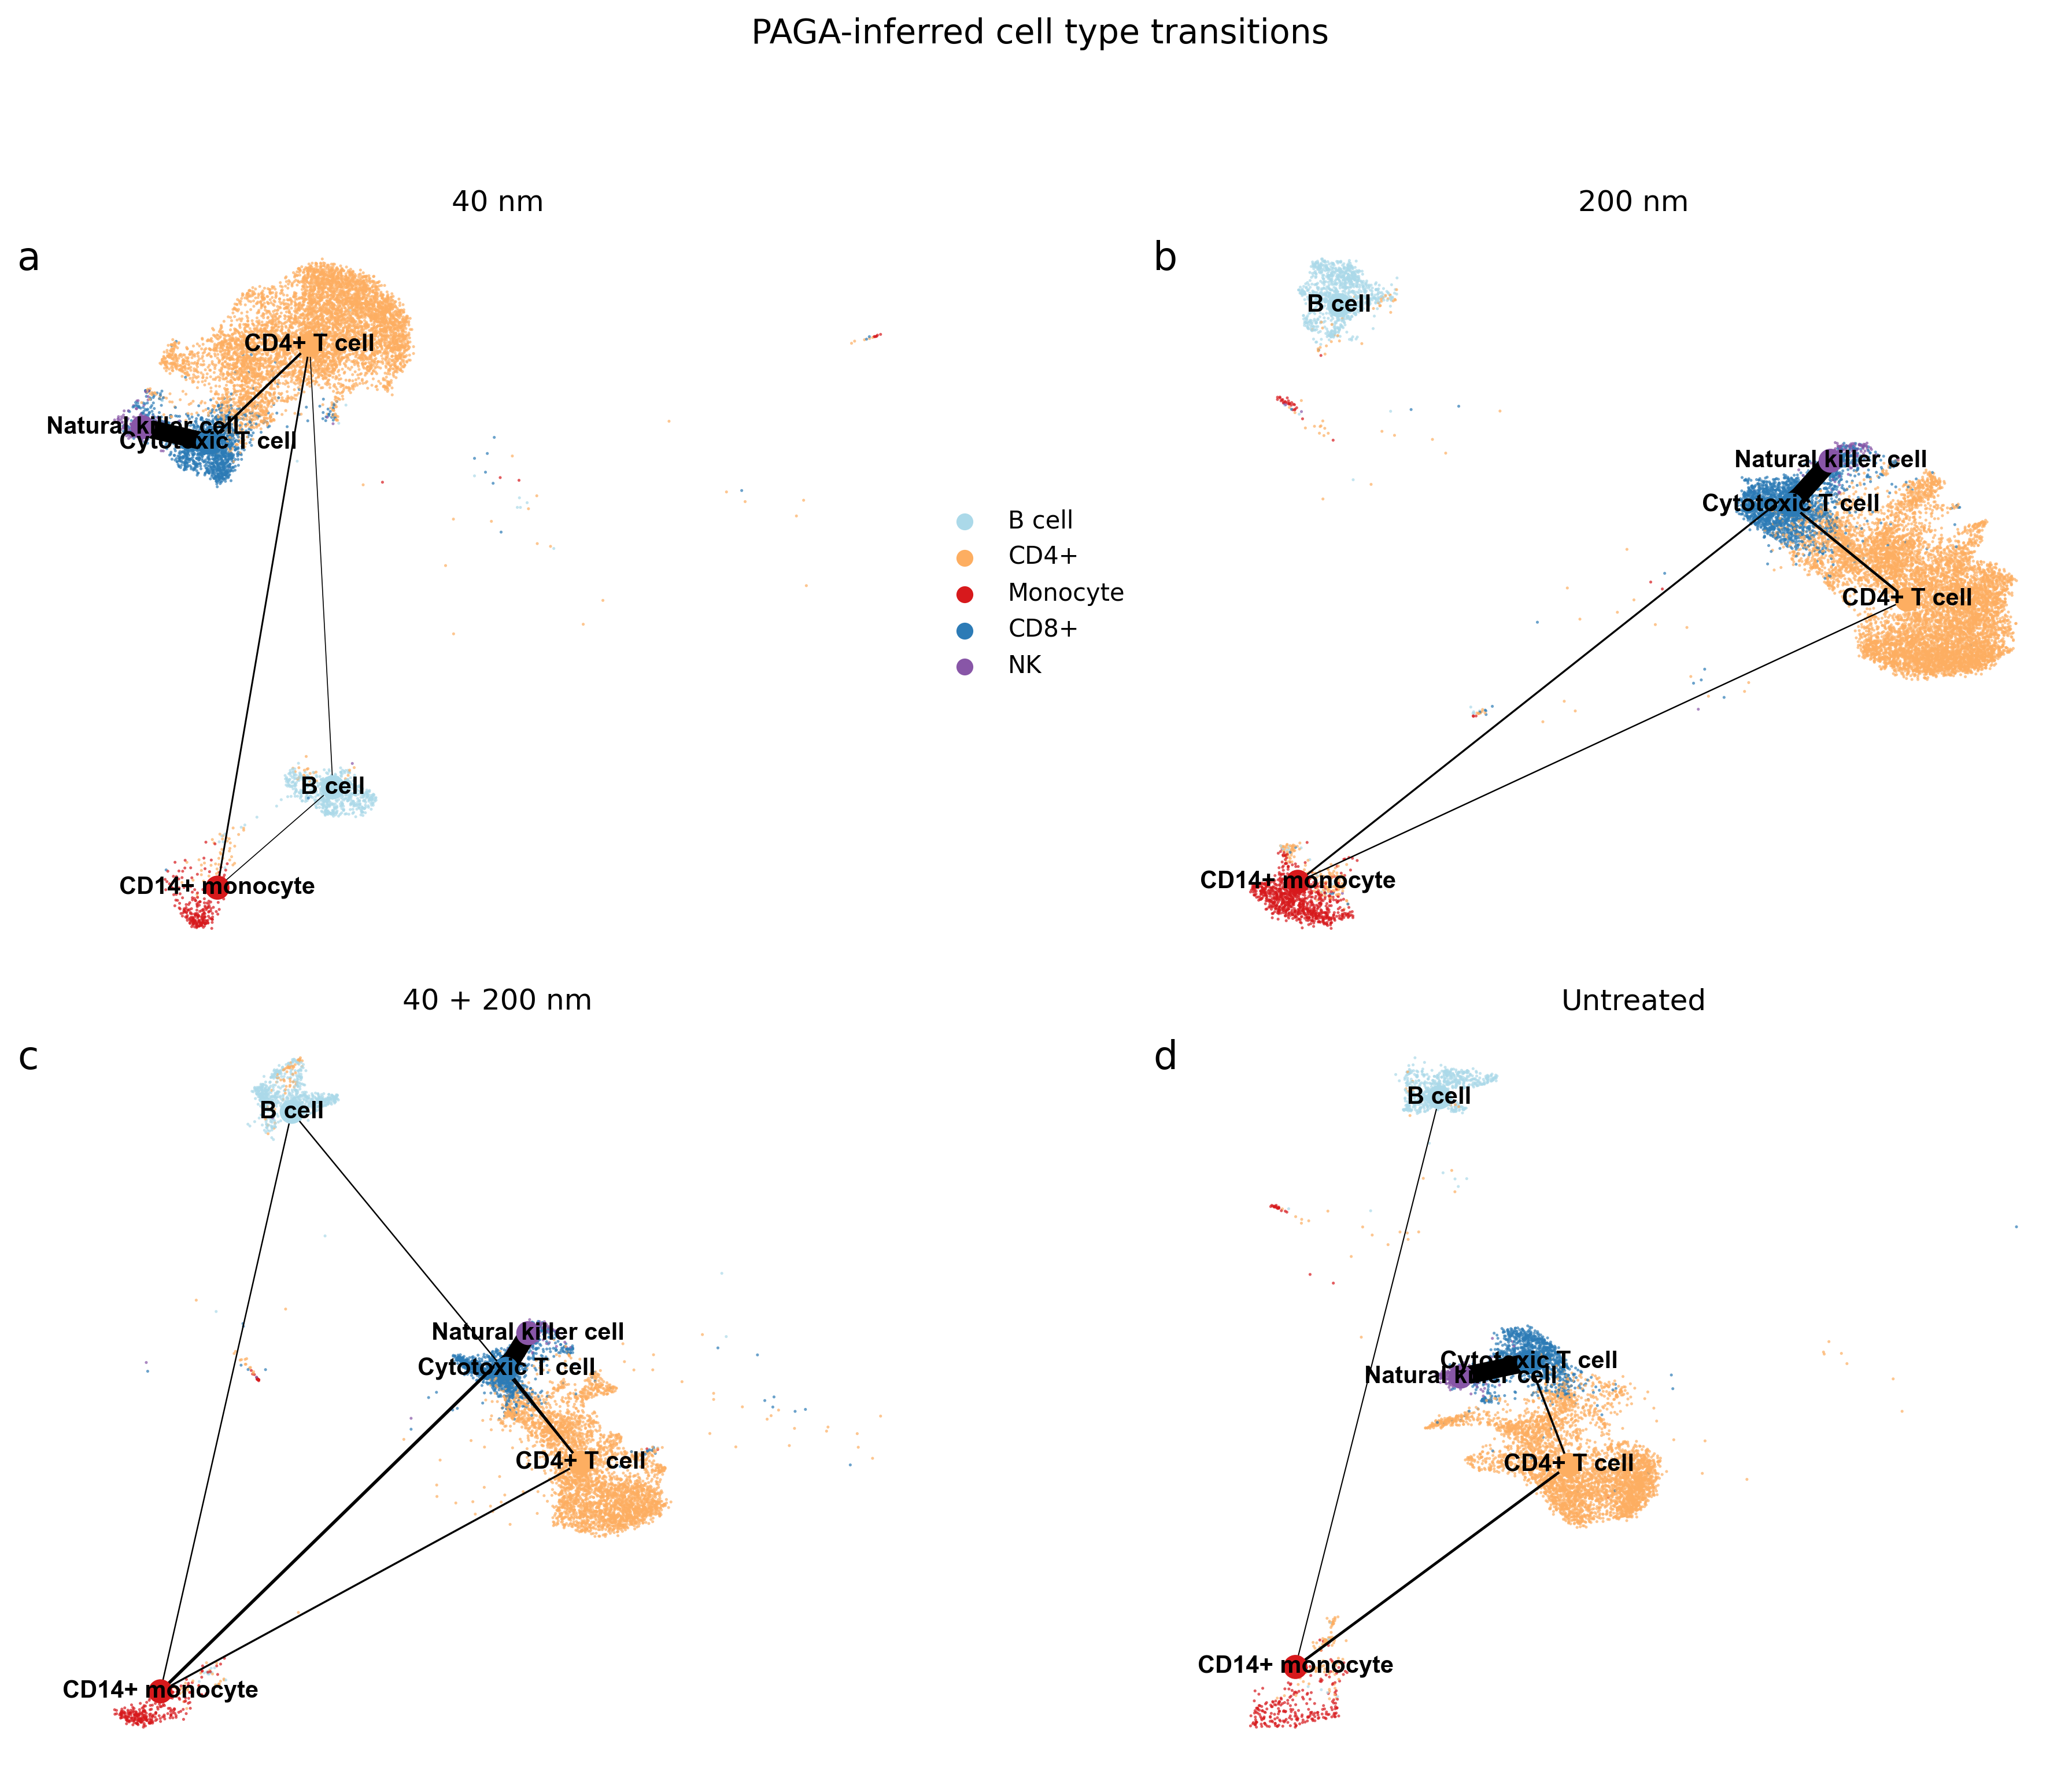

In [36]:
# ============================================================
# SUPPLEMENTARY FIGURE S7: PAGA-inferred Cell Type Transitions
# ============================================================

fig_s7, axes_s7 = plt.subplots(2, 2, figsize=(12, 10))
axes_s7 = axes_s7.flatten()
panel_labels = ['a', 'b', 'c', 'd']

for idx, sample in enumerate(sample_order):
    ax = axes_s7[idx]
    adata_s = adata_by_sample[sample]
    
    # Set cell type colors in adata.uns for consistent coloring
    adata_s.uns['CoDi_dist_colors'] = [
        CELL_TYPE_COLORS.get(ct, '#999999') 
        for ct in adata_s.obs['CoDi_dist'].cat.categories
    ]
    
    # Plot UMAP colored by cell type
    sc.pl.umap(
        adata_s,
        color='CoDi_dist',
        ax=ax,
        show=False,
        alpha=0.7,
        size=6,
        title=SAMPLE_LABELS[sample],
        legend_loc='right margin' if idx == 0 else None
    )
    
    # Compute cluster centroids in UMAP space for PAGA node positions
    cluster_labels = adata_s.obs['CoDi_dist'].cat.categories
    centroids = np.vstack([
        adata_s.obsm['X_umap'][adata_s.obs['CoDi_dist'] == cluster].mean(axis=0)
        for cluster in cluster_labels
    ])
    
    # Overlay PAGA graph
    sc.pl.paga(
        adata_s,
        color='CoDi_dist',
        ax=ax,
        pos=centroids,
        show=False,
        threshold=0.05,
        frameon=False,
        node_size_scale=0.5,
        node_size_power=0.01,
        edge_width_scale=1,
        title=''
    )
    
    # Style the title (no bold)
    ax.set_title(SAMPLE_LABELS[sample], fontsize=12, fontweight='normal', fontfamily='Liberation Sans')
    
    # Remove axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Add panel label
    ax.text(
        -0.07, 0.98, panel_labels[idx],
        transform=ax.transAxes,
        fontsize=16,
        fontweight='normal',
        fontfamily='Liberation Sans',
        va='top',
        ha='left'
    )

# Update legend labels to use short names
if axes_s7[0].get_legend():
    legend = axes_s7[0].get_legend()
    for text in legend.get_texts():
        original = text.get_text()
        short_name = CELL_TYPE_SHORT_MAP.get(original, original)
        text.set_text(short_name)
        text.set_fontfamily('Liberation Sans')
        text.set_fontweight('normal')

# Main title (no bold)
fig_s7.suptitle(
    'PAGA-inferred cell type transitions',
    y=1.02,
    fontsize=14,
    fontweight='normal',
    fontfamily='Liberation Sans'
)

fig_s7.tight_layout(rect=[0, 0, 1, 0.97])

# Save figure
fig_s7.savefig(FIG_DIR / 'Supplementary_Figure_S7_Trajectories.pdf', bbox_inches='tight', dpi=300)
logger.info(f"✓ Saved Supplementary Figure S7 to {FIG_DIR / 'Supplementary_Figure_S7_Trajectories.pdf'}")
plt.show()